# 01 — EDA (Exploratory Data Analysis) — Titanic

**Objetivo:** comprender la estructura del dataset, calidad de datos, distribuciones y relaciones con la supervivencia.  
**Criterios de salida:**  
- Tablas en `results/tables/` con descripciones.  
- Figuras en `results/figures/` (≥300 DPI, paleta colorblind, títulos y *captions*).  
- Historias claras por gráfico y estilo consistente.

In [40]:
import sys, os
from pathlib import Path

# Detecta el root del repo buscando la carpeta 'src'
candidates = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
PROJECT_ROOT = None
for c in candidates:
    if (c / "src").exists():
        PROJECT_ROOT = c
        break

if PROJECT_ROOT is None:
    raise RuntimeError("No se encontró la carpeta 'src' en los niveles superiores.")

# Inserta el root al inicio del sys.path (prioridad)
sys.path.insert(0, str(PROJECT_ROOT))

os.environ["PYTHONPATH"] = str(PROJECT_ROOT) + os.pathsep + os.environ.get("PYTHONPATH", "")

print("Project root:", PROJECT_ROOT)

Project root: c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject


In [41]:
import pandas as pd
import numpy as np
from IPython.display import Image, display

from src.utils import p, ensure_dirs, read_csv, save_table
from src.preprocessing import normalize_columns, engineer_basic_features
from src.visualization import (
    plot_hist, plot_bar_counts, plot_rate_bar, plot_corr_heatmap, plot_grouped_rate_bars, plot_survival_heatmap
)

DATA_RAW = p("data", "raw", "Titanic-Dataset.csv")
ensure_dirs()

In [42]:
df_raw = read_csv(DATA_RAW)
df_raw = normalize_columns(df_raw)
df = engineer_basic_features(df_raw)

# Mapa cómodo de nombres (tolerante a mayúsculas/minúsculas)
colmap = {c.lower(): c for c in df.columns}
def g(name): return colmap.get(name.lower())

SURV, PCLASS, SEX, AGE, FARE, EMB = map(g, ["Survived","Pclass","Sex","Age","Fare","Embarked"])

In [43]:
# Resumen del dataset
shape_tbl = pd.DataFrame({"rows":[len(df)], "columns":[df.shape[1]]})
schema = pd.DataFrame({
    "column": df.columns,
    "dtype": [df[c].dtype for c in df.columns],
    "non_null": [df[c].notna().sum() for c in df.columns],
    "missing": [df[c].isna().sum() for c in df.columns],
})
schema["missing_%"] = (schema["missing"]/len(df)*100).round(2)

save_table(shape_tbl, "eda_shape", "Tamaño del dataset (filas/columnas).")
save_table(schema, "eda_schema_missing", "Esquema de columnas con tipos y porcentaje de faltantes.")
schema.sort_values("missing_%", ascending=False).head(10)

,column,dtype,non_null,missing,missing_%
10,Cabin,object,204,687,77.10
5,Age,float64,714,177,19.87
15,Age_bin,category,714,177,19.87
11,Embarked,object,889,2,0.22
1,Survived,int64,891,0,0.00
0,PassengerId,int64,891,0,0.00
6,SibSp,int64,891,0,0.00
2,Pclass,int64,891,0,0.00
3,Name,object,891,0,0.00
4,Sex,object,891,0,0.00


In [44]:
# Distribuciones de variables categóricas
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if c not in num_cols]

desc_num = df[num_cols].describe().T
desc_num["missing_%"] = (df[num_cols].isna().mean()*100).round(2)
save_table(desc_num.reset_index().rename(columns={"index":"feature"}), "eda_numeric_describe",
           "Estadísticos descriptivos de variables numéricas con % de faltantes.")
desc_num.head(10)

,count,mean,std,min,25%,50%,75%,max,missing_%
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.500000,891.0000,0.00
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.000000,1.0000,0.00
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.000000,3.0000,0.00
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.000000,80.0000,19.87
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.000000,8.0000,0.00
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.000000,6.0000,0.00
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.000000,512.3292,0.00
FamilySize,891.0,1.904602,1.613459,1.00,1.0000,1.0000,2.000000,11.0000,0.00
IsAlone,891.0,0.602694,0.489615,0.00,0.0000,1.0000,1.000000,1.0000,0.00
FarePerPerson,891.0,19.916375,35.841257,0.00,7.2500,8.3000,23.666667,512.3292,0.00


In [45]:
# Distribuciones de variables categóricas
tables_info = []
for c in cat_cols:
    vc = df[c].value_counts(dropna=False).reset_index()
    vc.columns = [c, "count"]
    save_table(vc, f"eda_counts_{c}",
               f"Conteo de categorías para {c} (incluyendo NaN).")

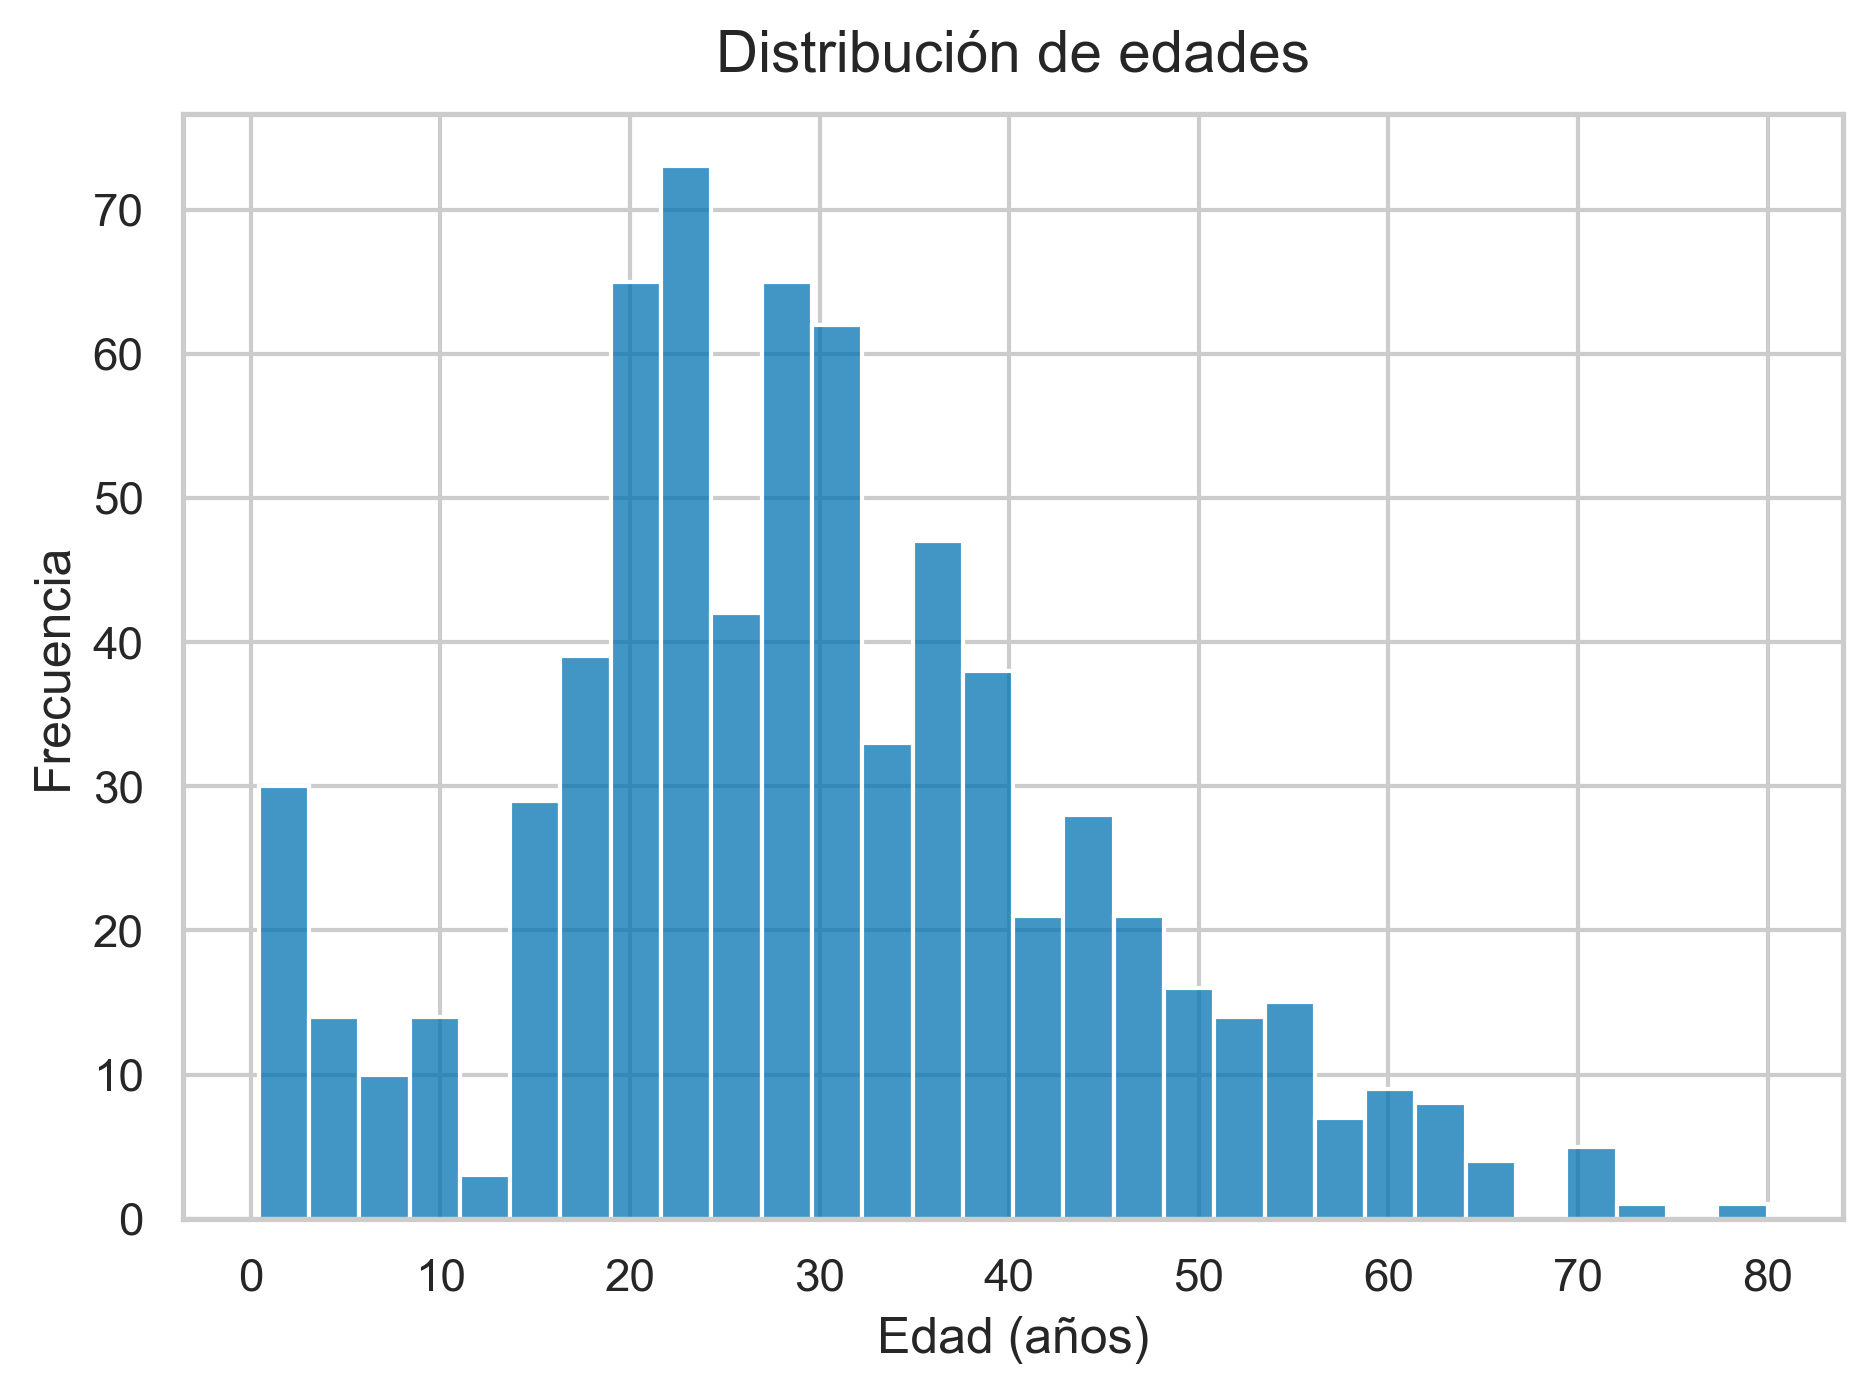

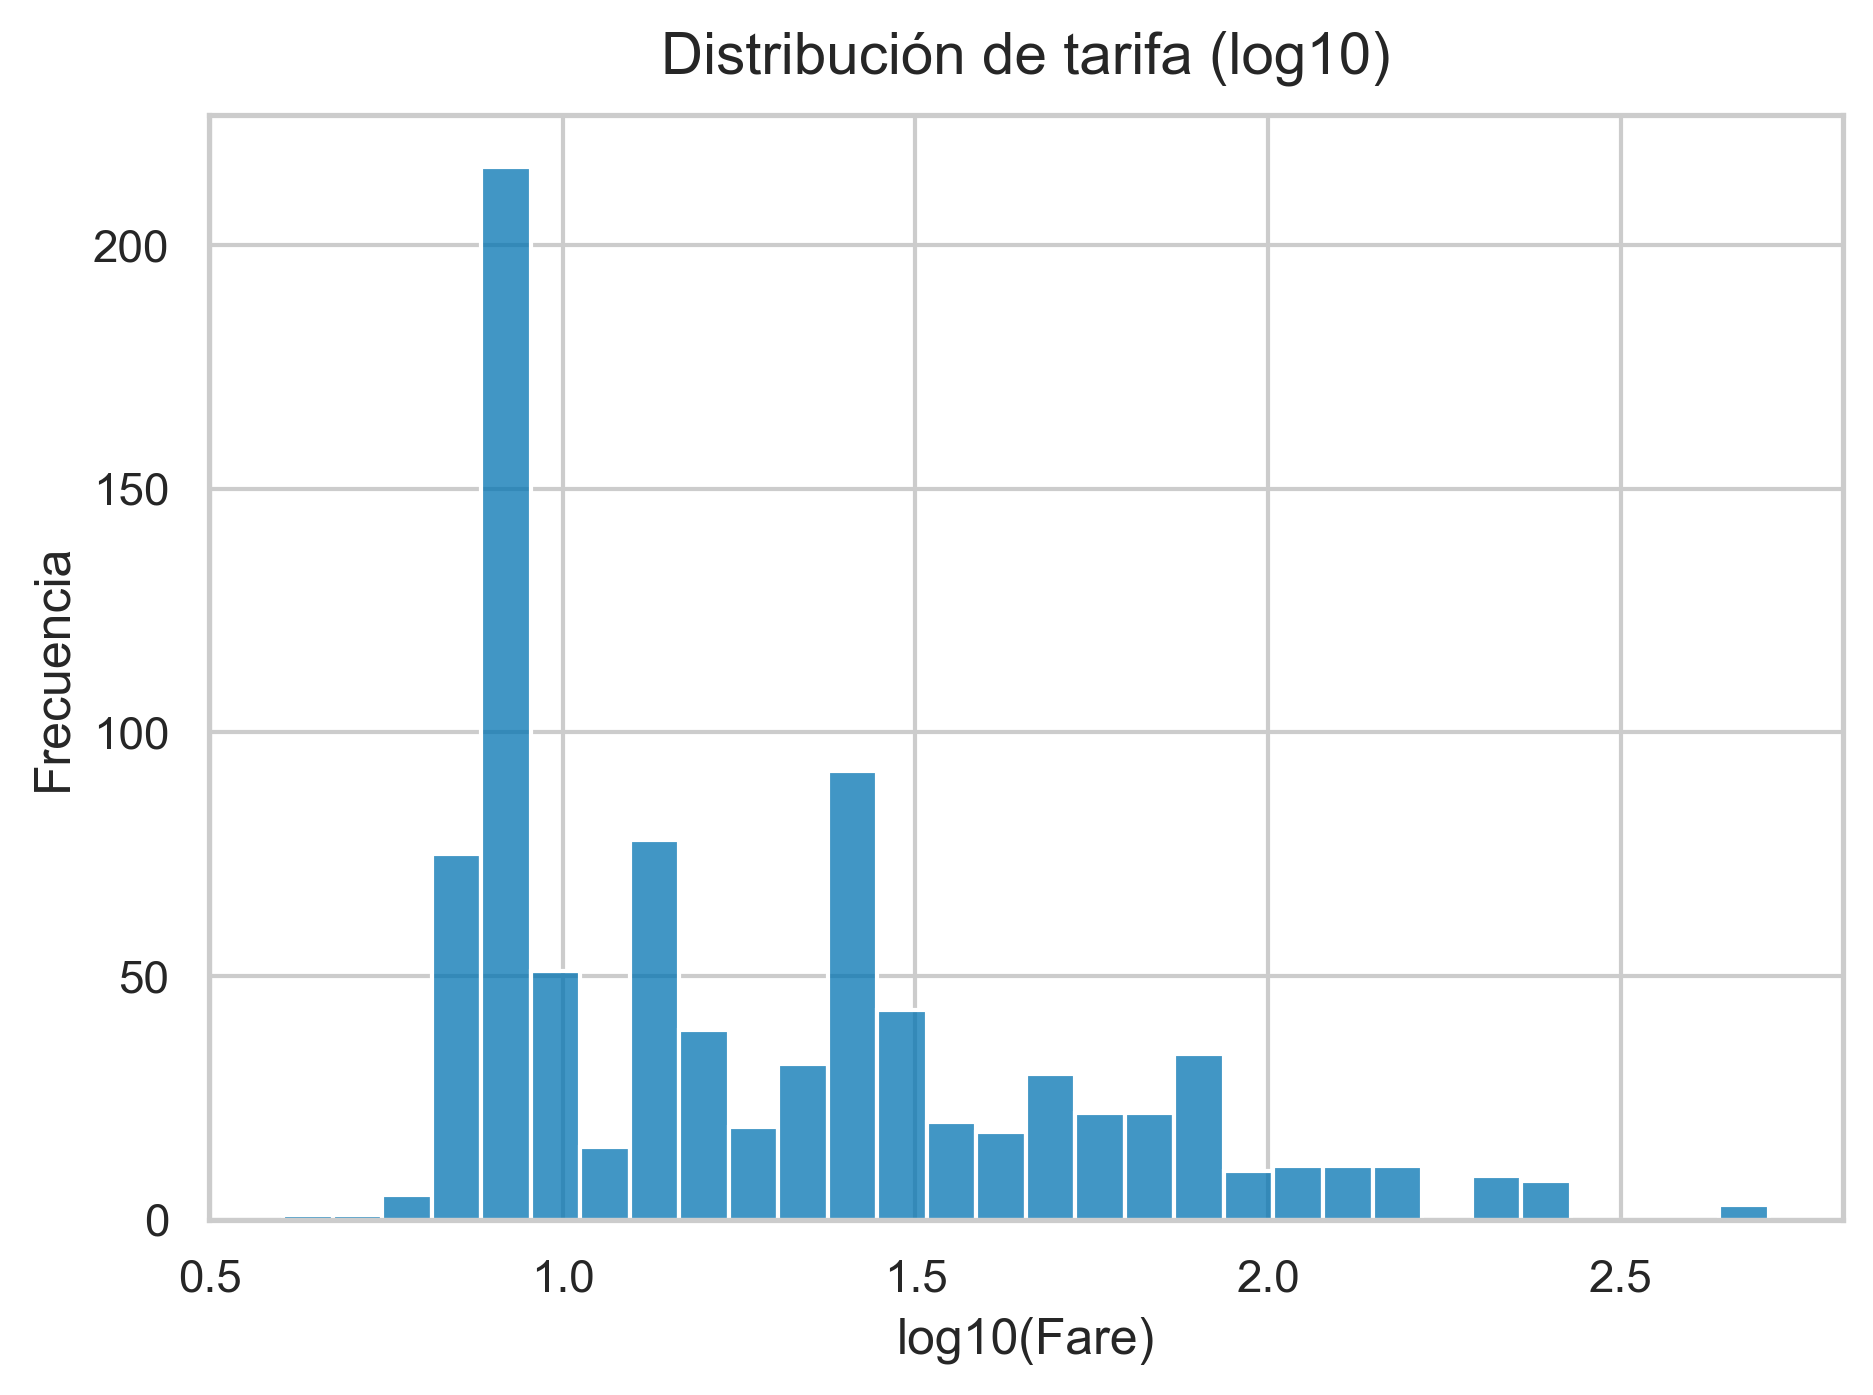

c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, ax=ax, palette=CB_PALETTE)
c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:42: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(x=vc.index.astype(str), y=vc.values, ax=ax, palette=CB_PALETTE)


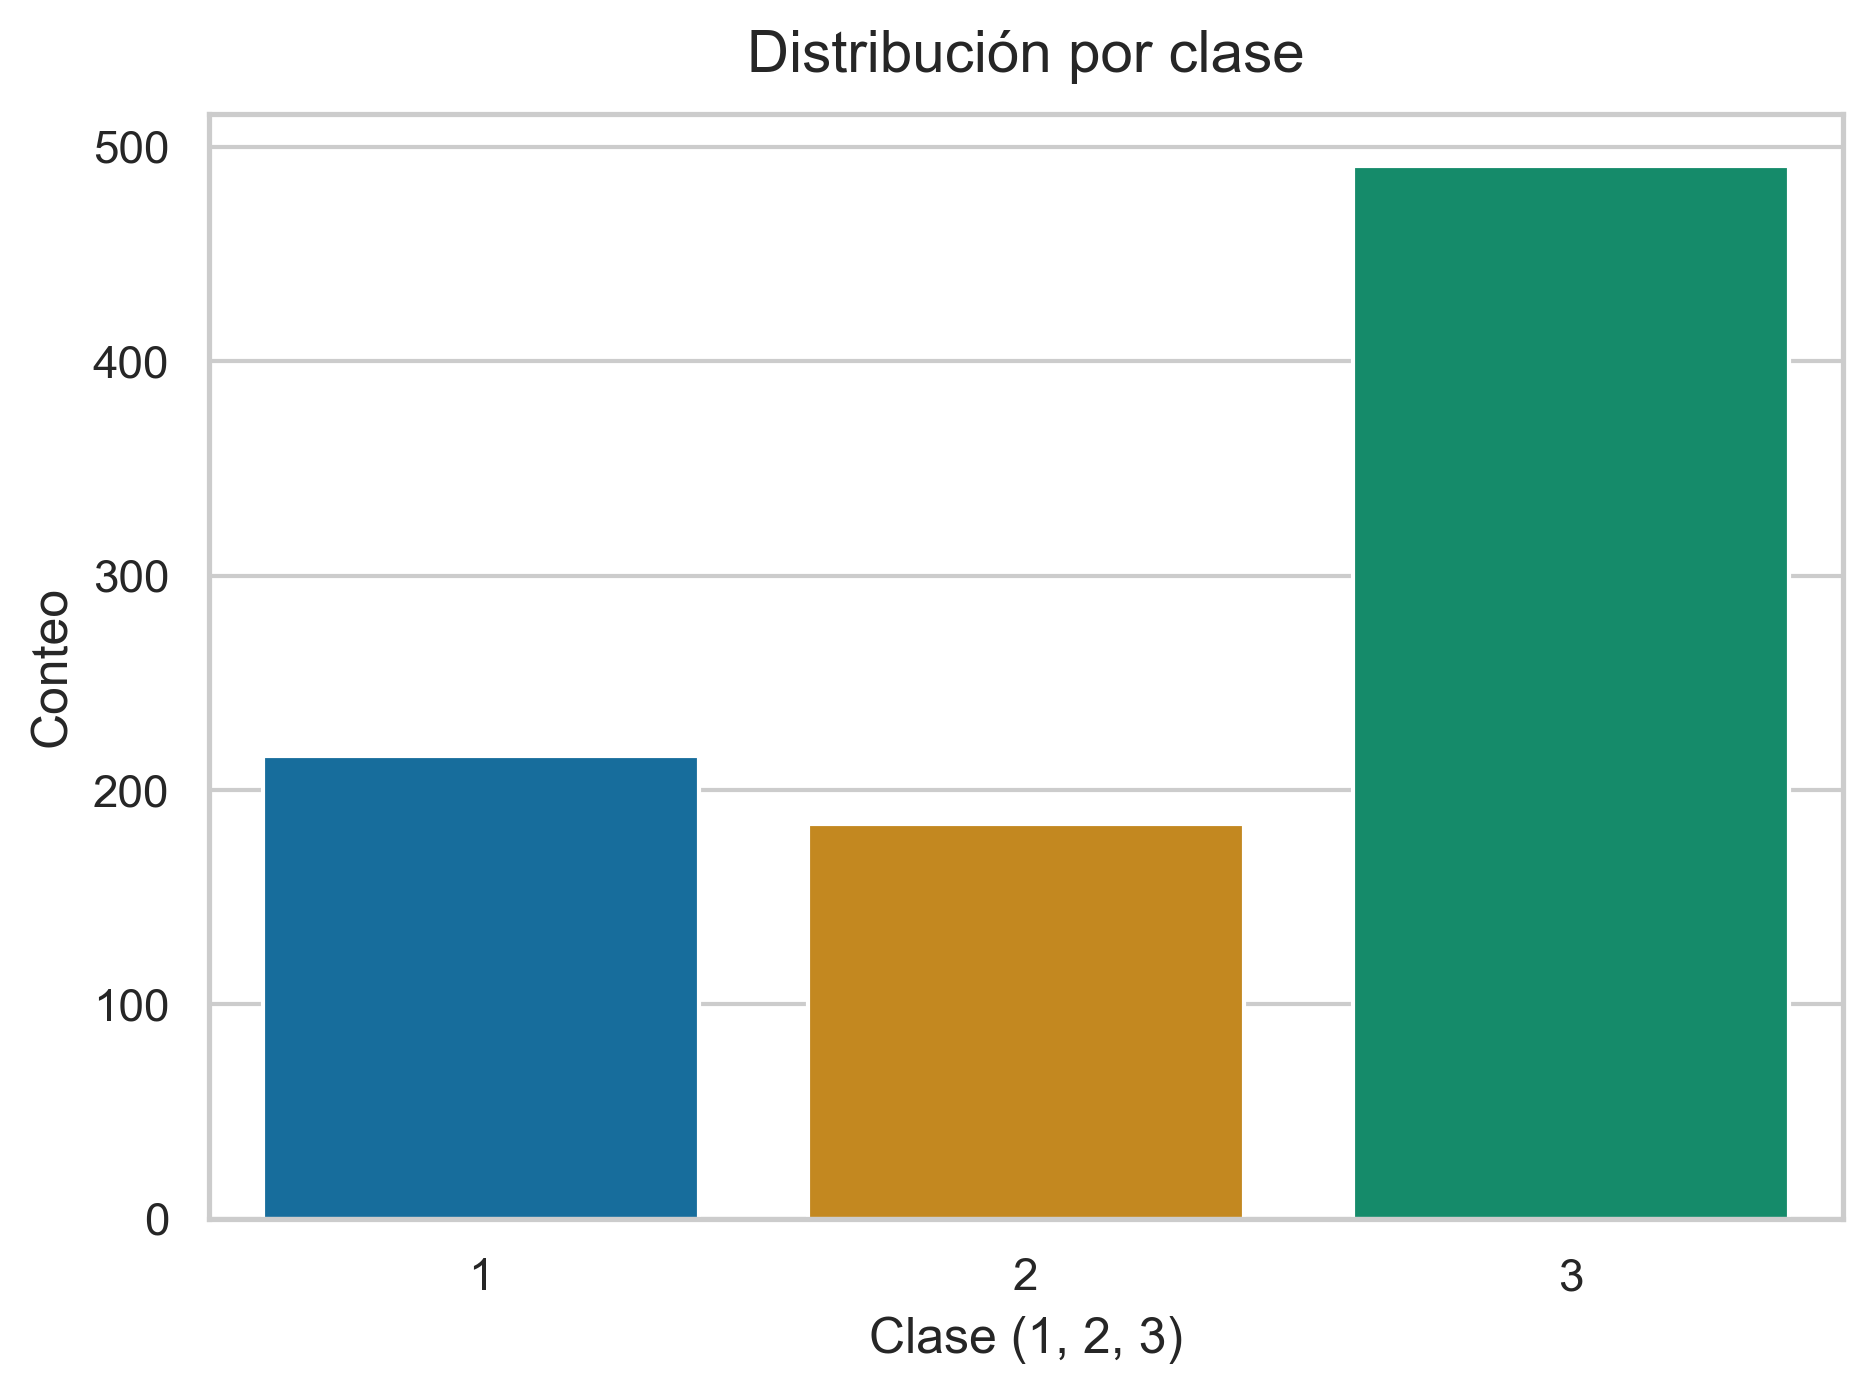

c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, ax=ax, palette=CB_PALETTE)
c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:42: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(x=vc.index.astype(str), y=vc.values, ax=ax, palette=CB_PALETTE)


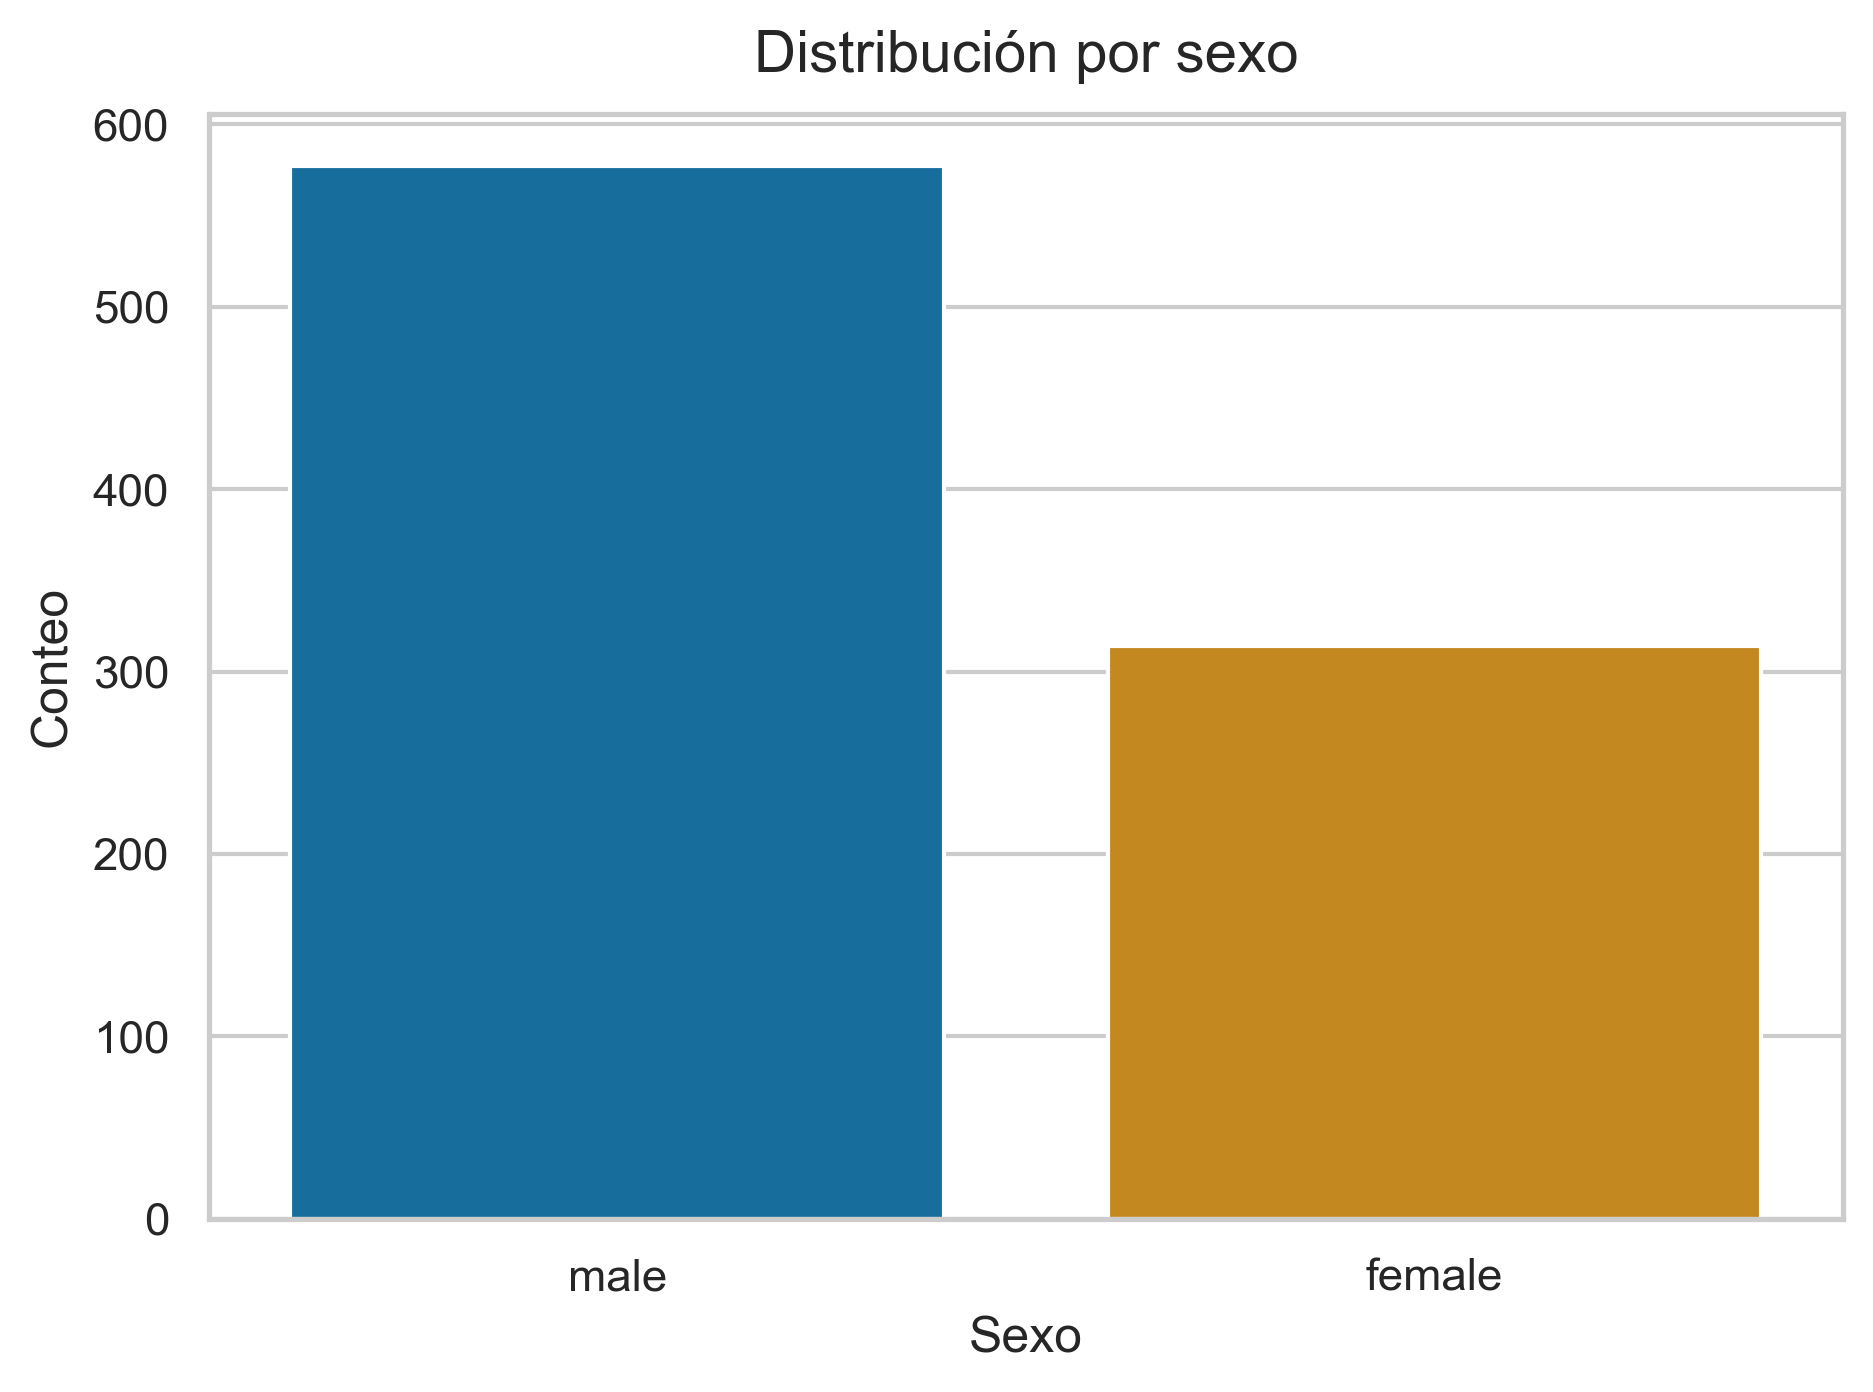

c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index.astype(str), y=vc.values, ax=ax, palette=CB_PALETTE)
c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:42: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x=vc.index.astype(str), y=vc.values, ax=ax, palette=CB_PALETTE)


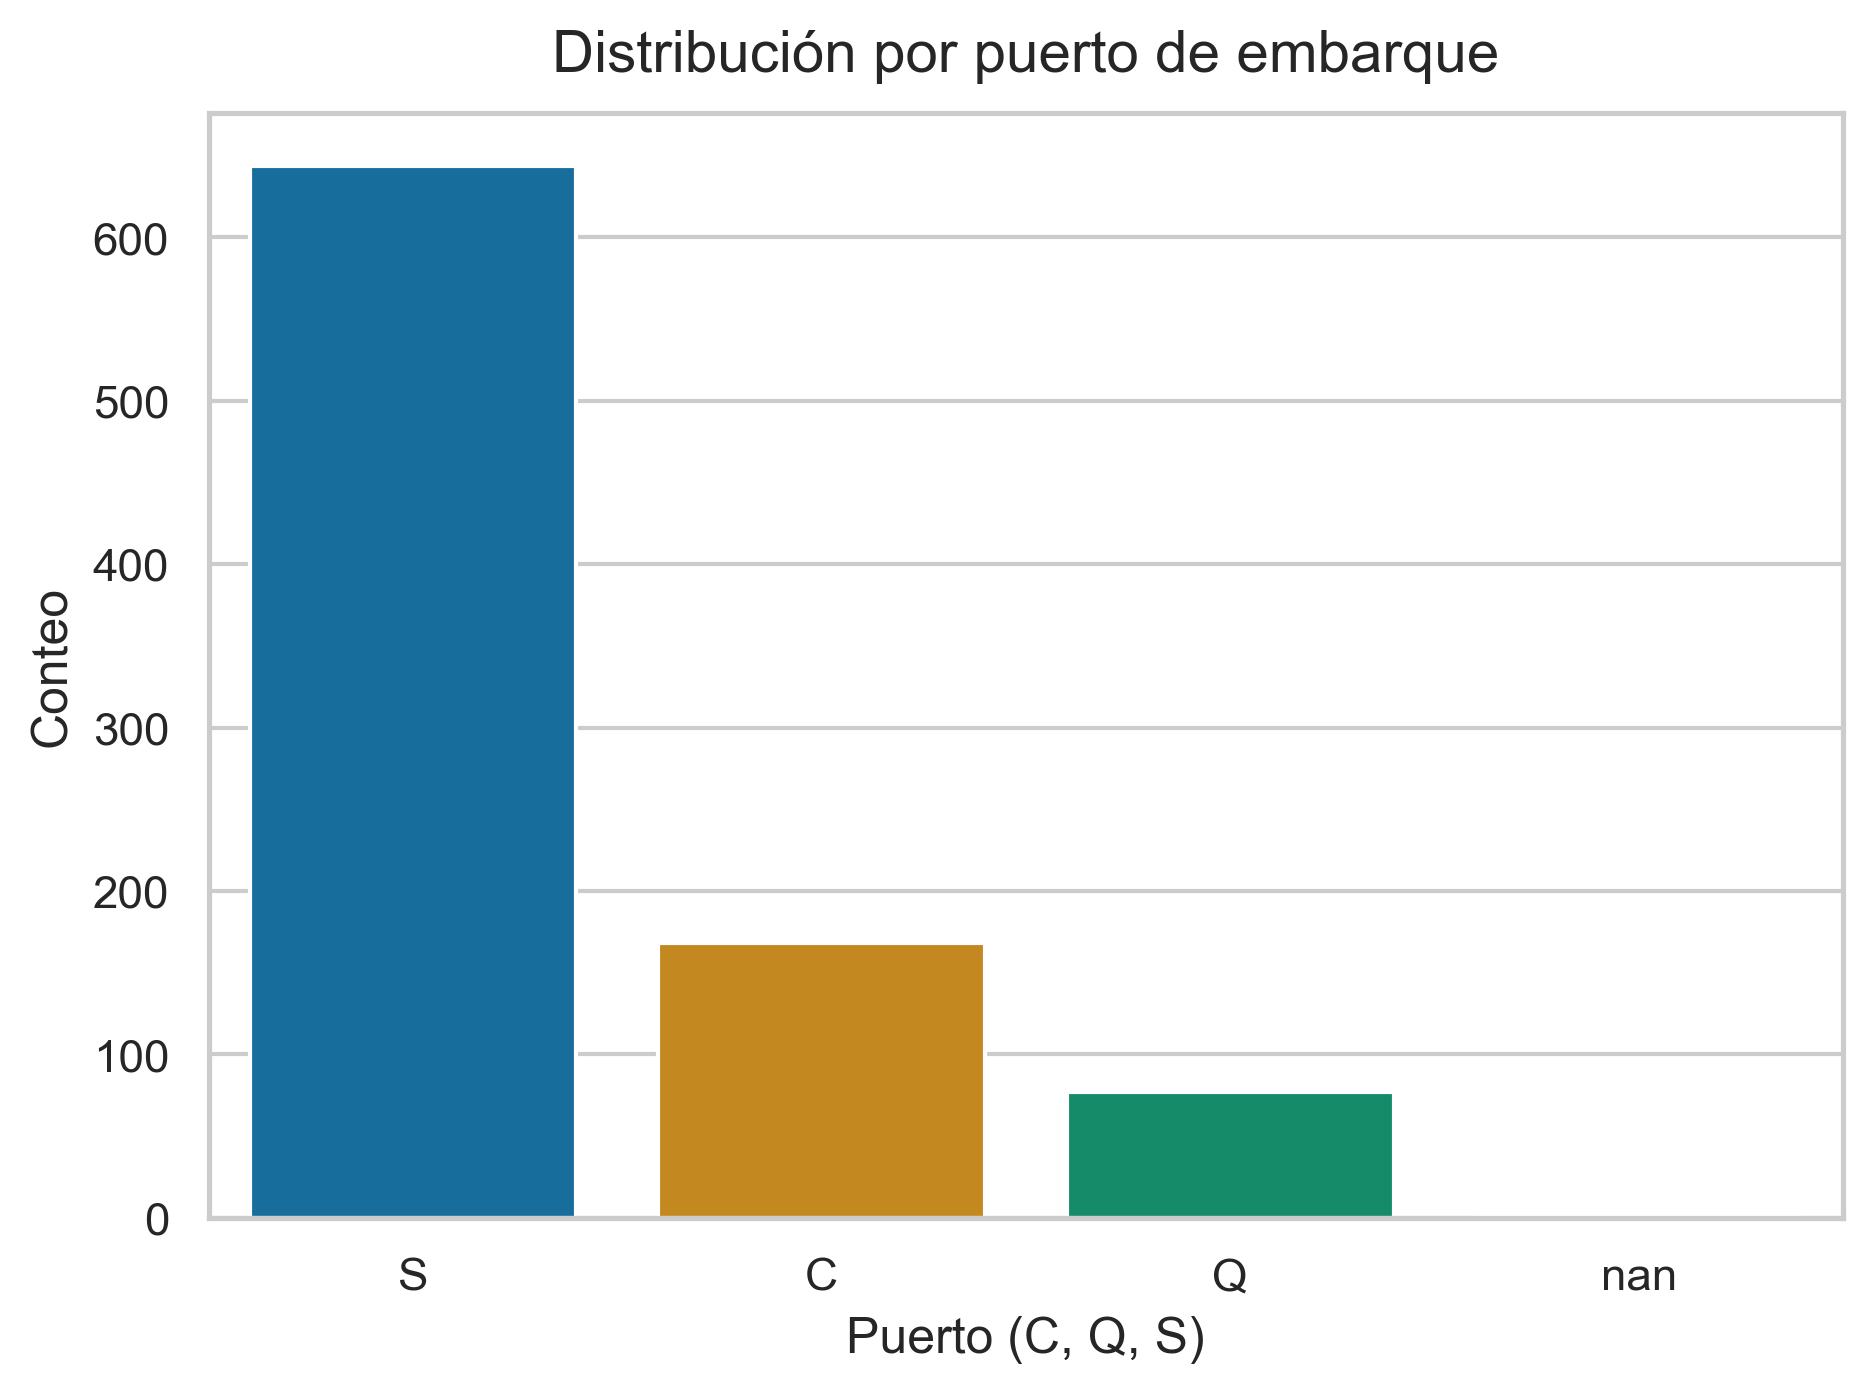

In [46]:
if AGE:
    path = plot_hist(
        df, AGE, bins=30, name="hist_age",
        title="Distribución de edades",
        xlabel="Edad (años)",
        caption="La mayoría de pasajeros se concentran entre 20 y 40 años; hay presencia de niños y adultos mayores."
    )
    display(Image(filename=str(path)))

if FARE:
    df["_Fare_log10"] = np.log10(df[FARE].replace(0, np.nan))
    path = plot_hist(
        df, "_Fare_log10", bins=30, name="hist_fare_log10",
        title="Distribución de tarifa (log10)",
        xlabel="log10(Fare)",
        caption="Las tarifas muestran fuerte asimetría: pocas observaciones con precios muy altos; se recomienda trabajar en escala log."
    )
    display(Image(filename=str(path)))

if PCLASS:
    order = sorted(df[PCLASS].dropna().unique())
    path = plot_bar_counts(
        df, PCLASS, order=order, name="bar_counts_pclass",
        title="Distribución por clase",
        xlabel="Clase (1, 2, 3)",
        caption="Predomina 3ra clase; esto influye en condiciones de cabina y acceso a botes."
    )
    display(Image(filename=str(path)))

if SEX:
    path = plot_bar_counts(
        df, SEX, name="bar_counts_sex",
        title="Distribución por sexo",
        xlabel="Sexo",
        caption="Más pasajeros hombres que mujeres; relevante dado el protocolo 'women & children first'."
    )
    display(Image(filename=str(path)))

if EMB:
    path = plot_bar_counts(
        df, EMB, name="bar_counts_embarked",
        title="Distribución por puerto de embarque",
        xlabel="Puerto (C, Q, S)",
        caption="Southampton (S) concentra la mayoría; Cherbourg (C) suele asociarse a mayor proporción de primera clase."
    )
    display(Image(filename=str(path)))

c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=s.index.astype(str), y=s.values, ax=ax, palette=CB_PALETTE)
c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:53: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(x=s.index.astype(str), y=s.values, ax=ax, palette=CB_PALETTE)


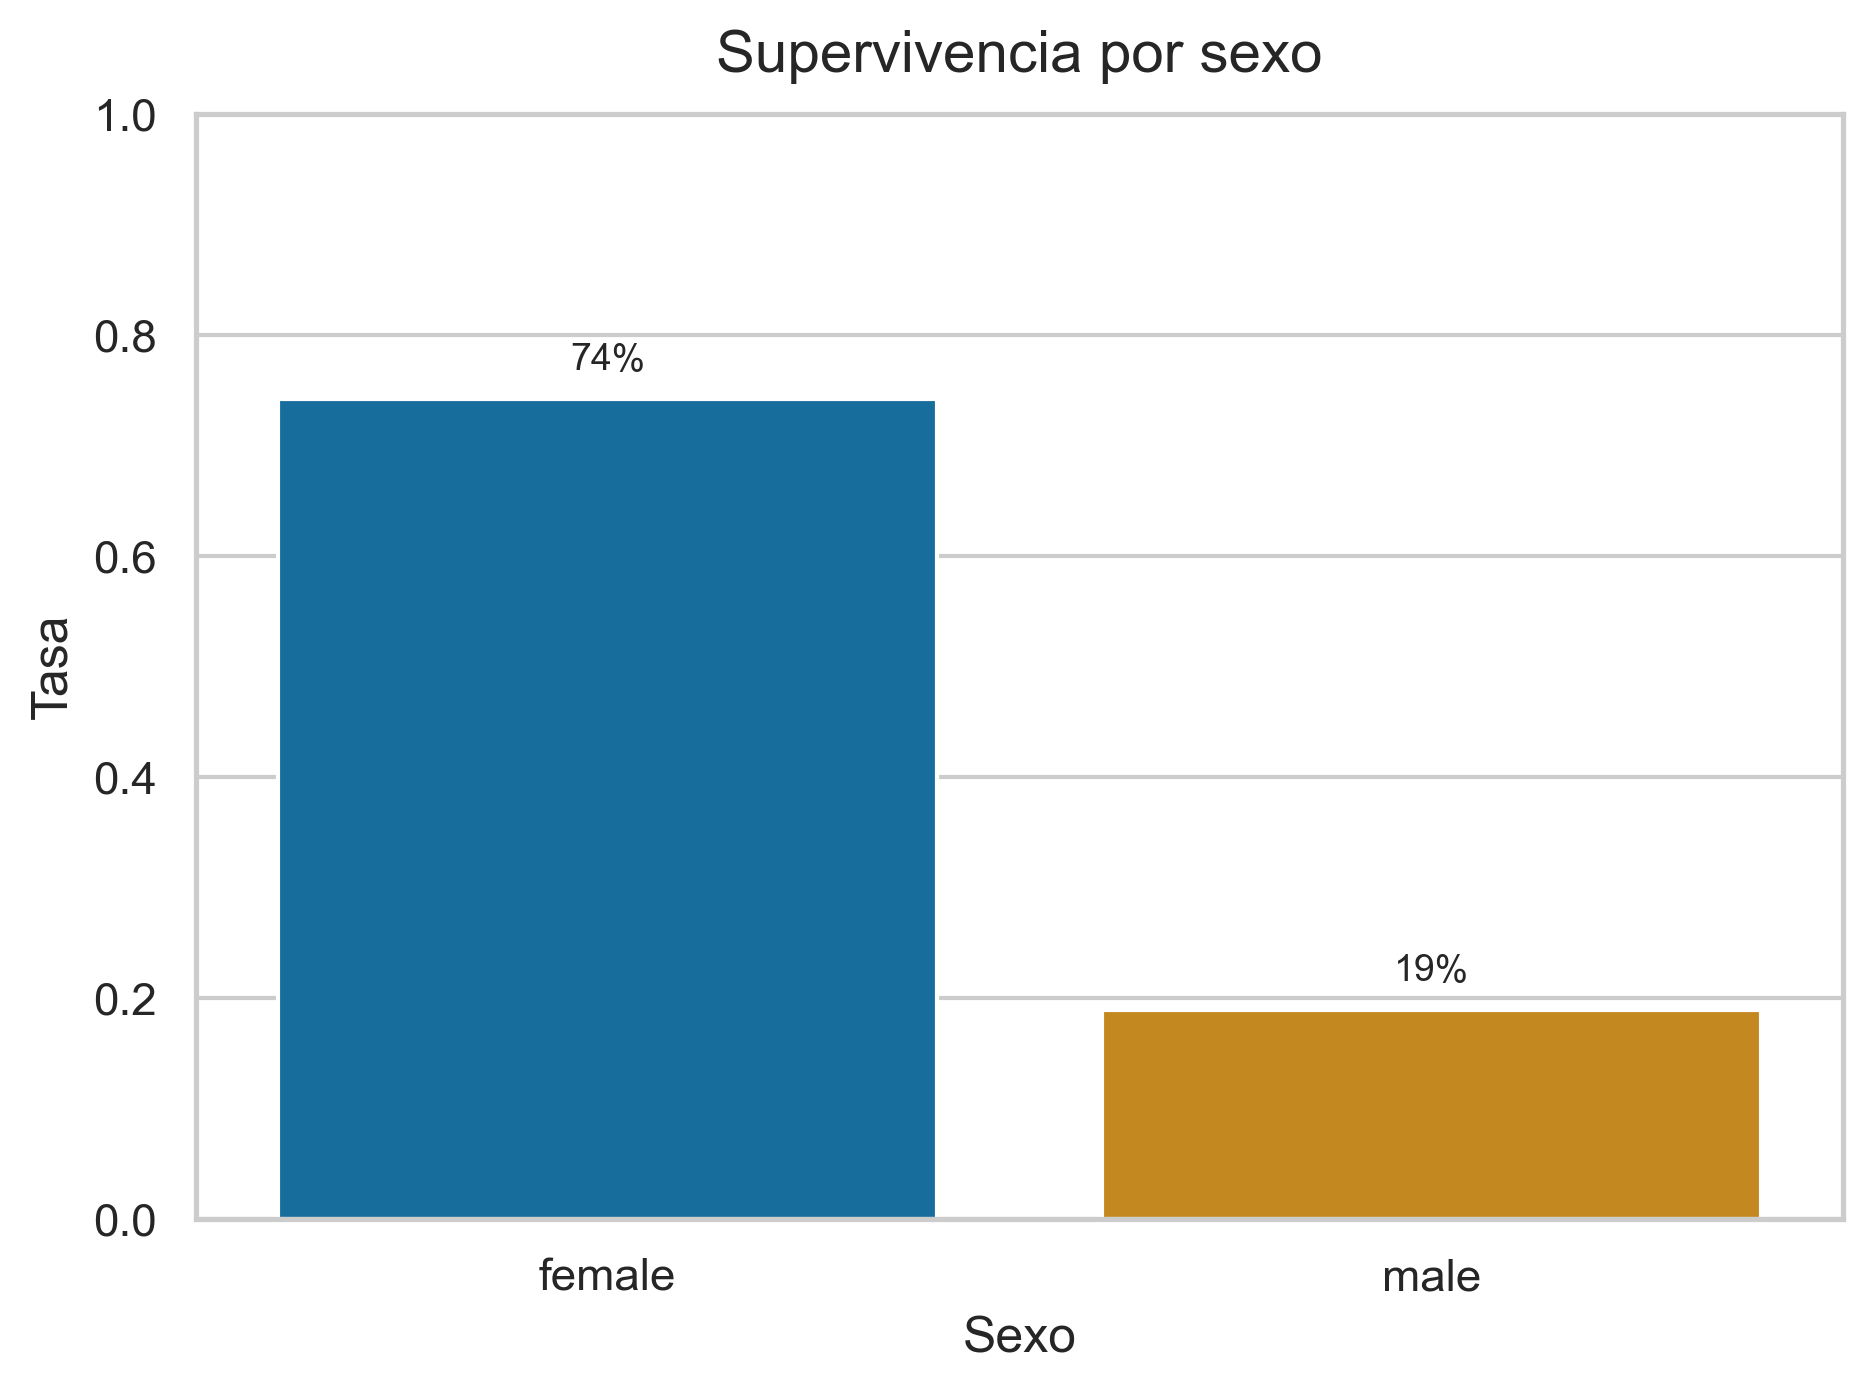

c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=s.index.astype(str), y=s.values, ax=ax, palette=CB_PALETTE)
c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:53: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(x=s.index.astype(str), y=s.values, ax=ax, palette=CB_PALETTE)


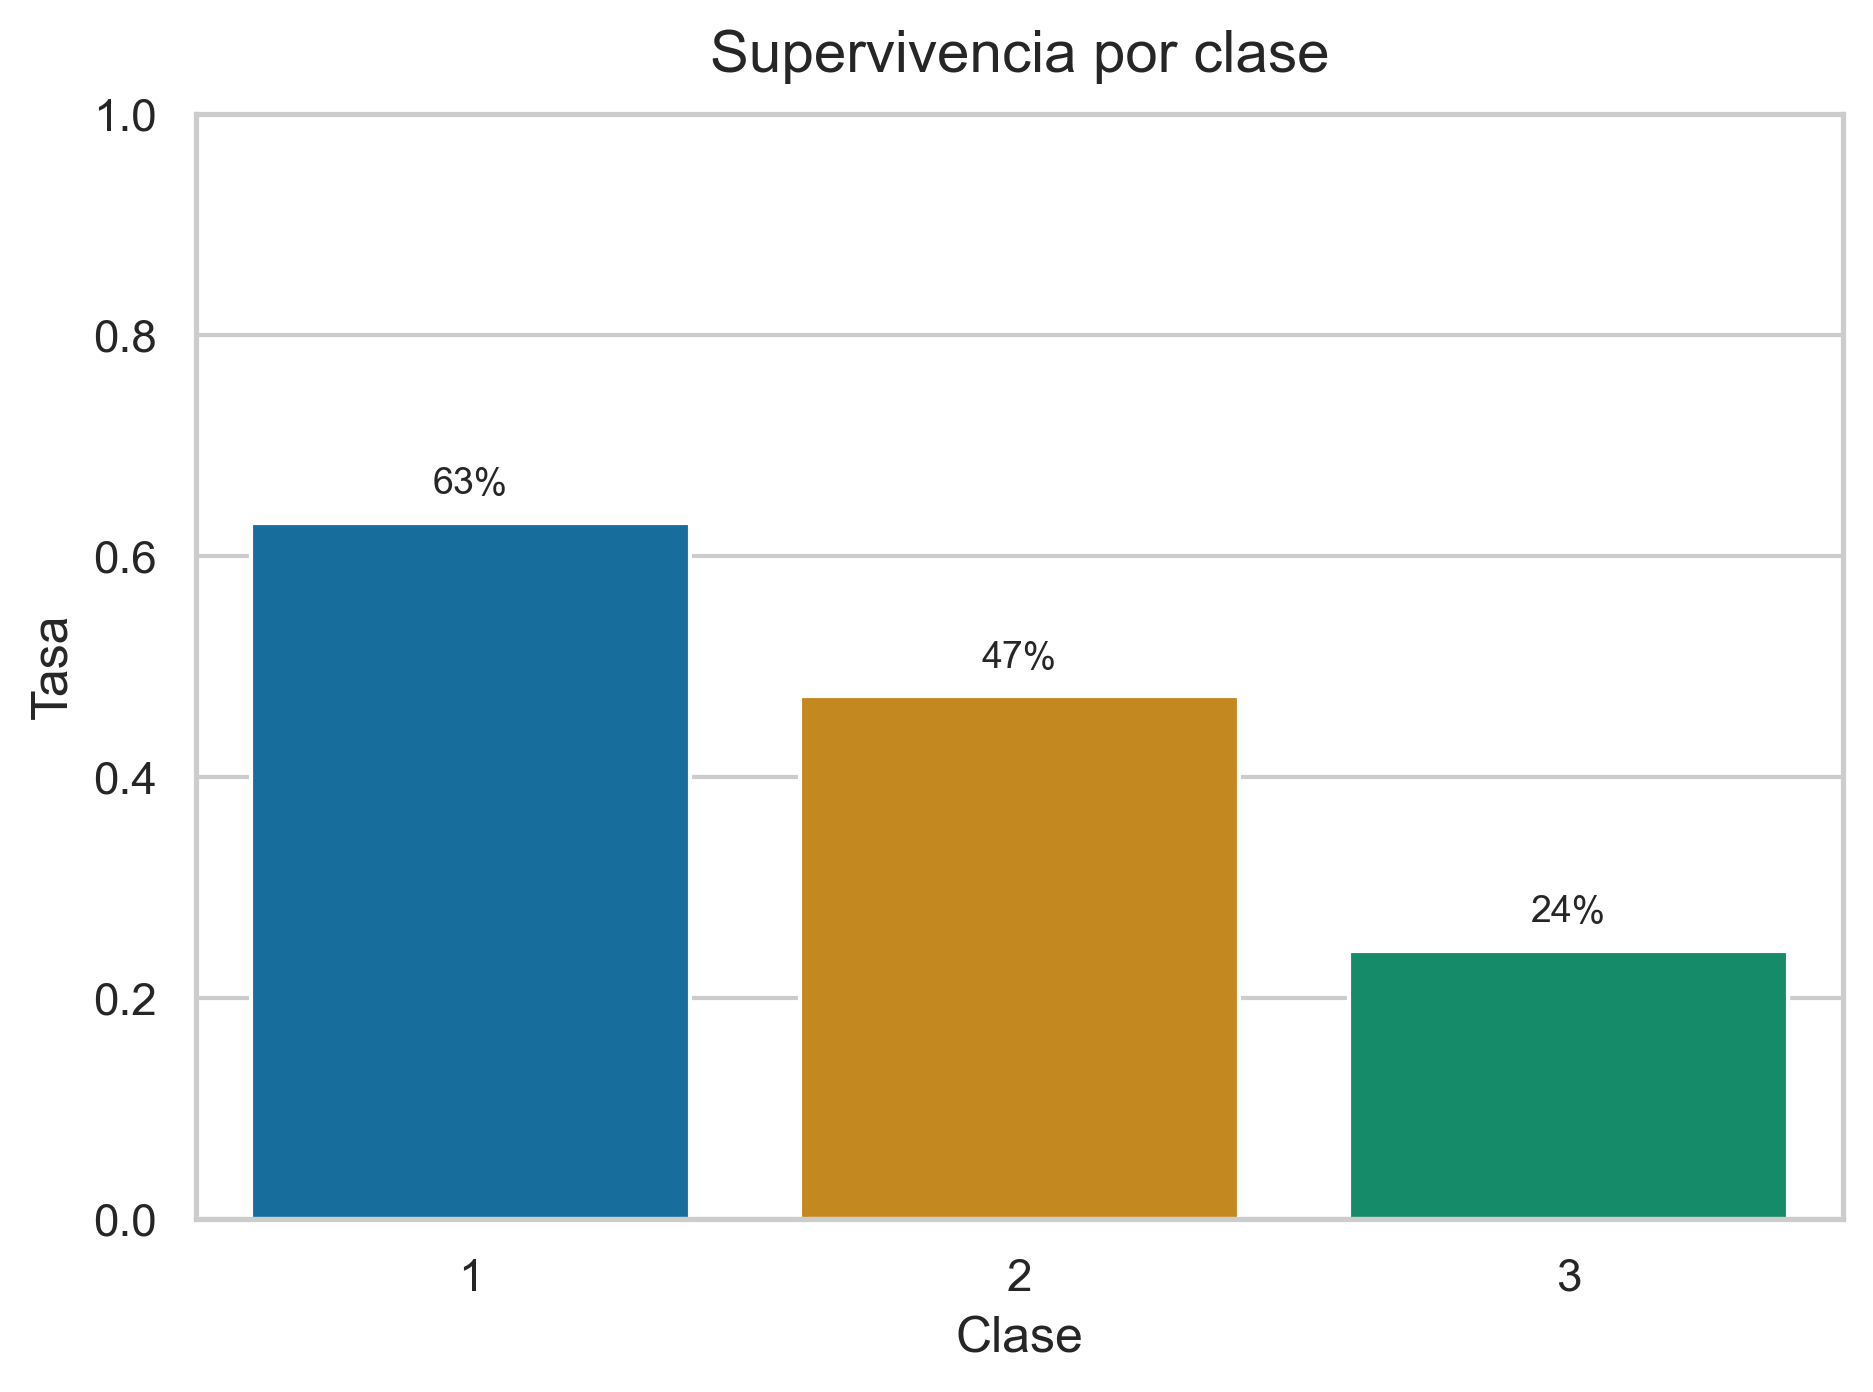

c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=s.index.astype(str), y=s.values, ax=ax, palette=CB_PALETTE)
c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:53: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(x=s.index.astype(str), y=s.values, ax=ax, palette=CB_PALETTE)


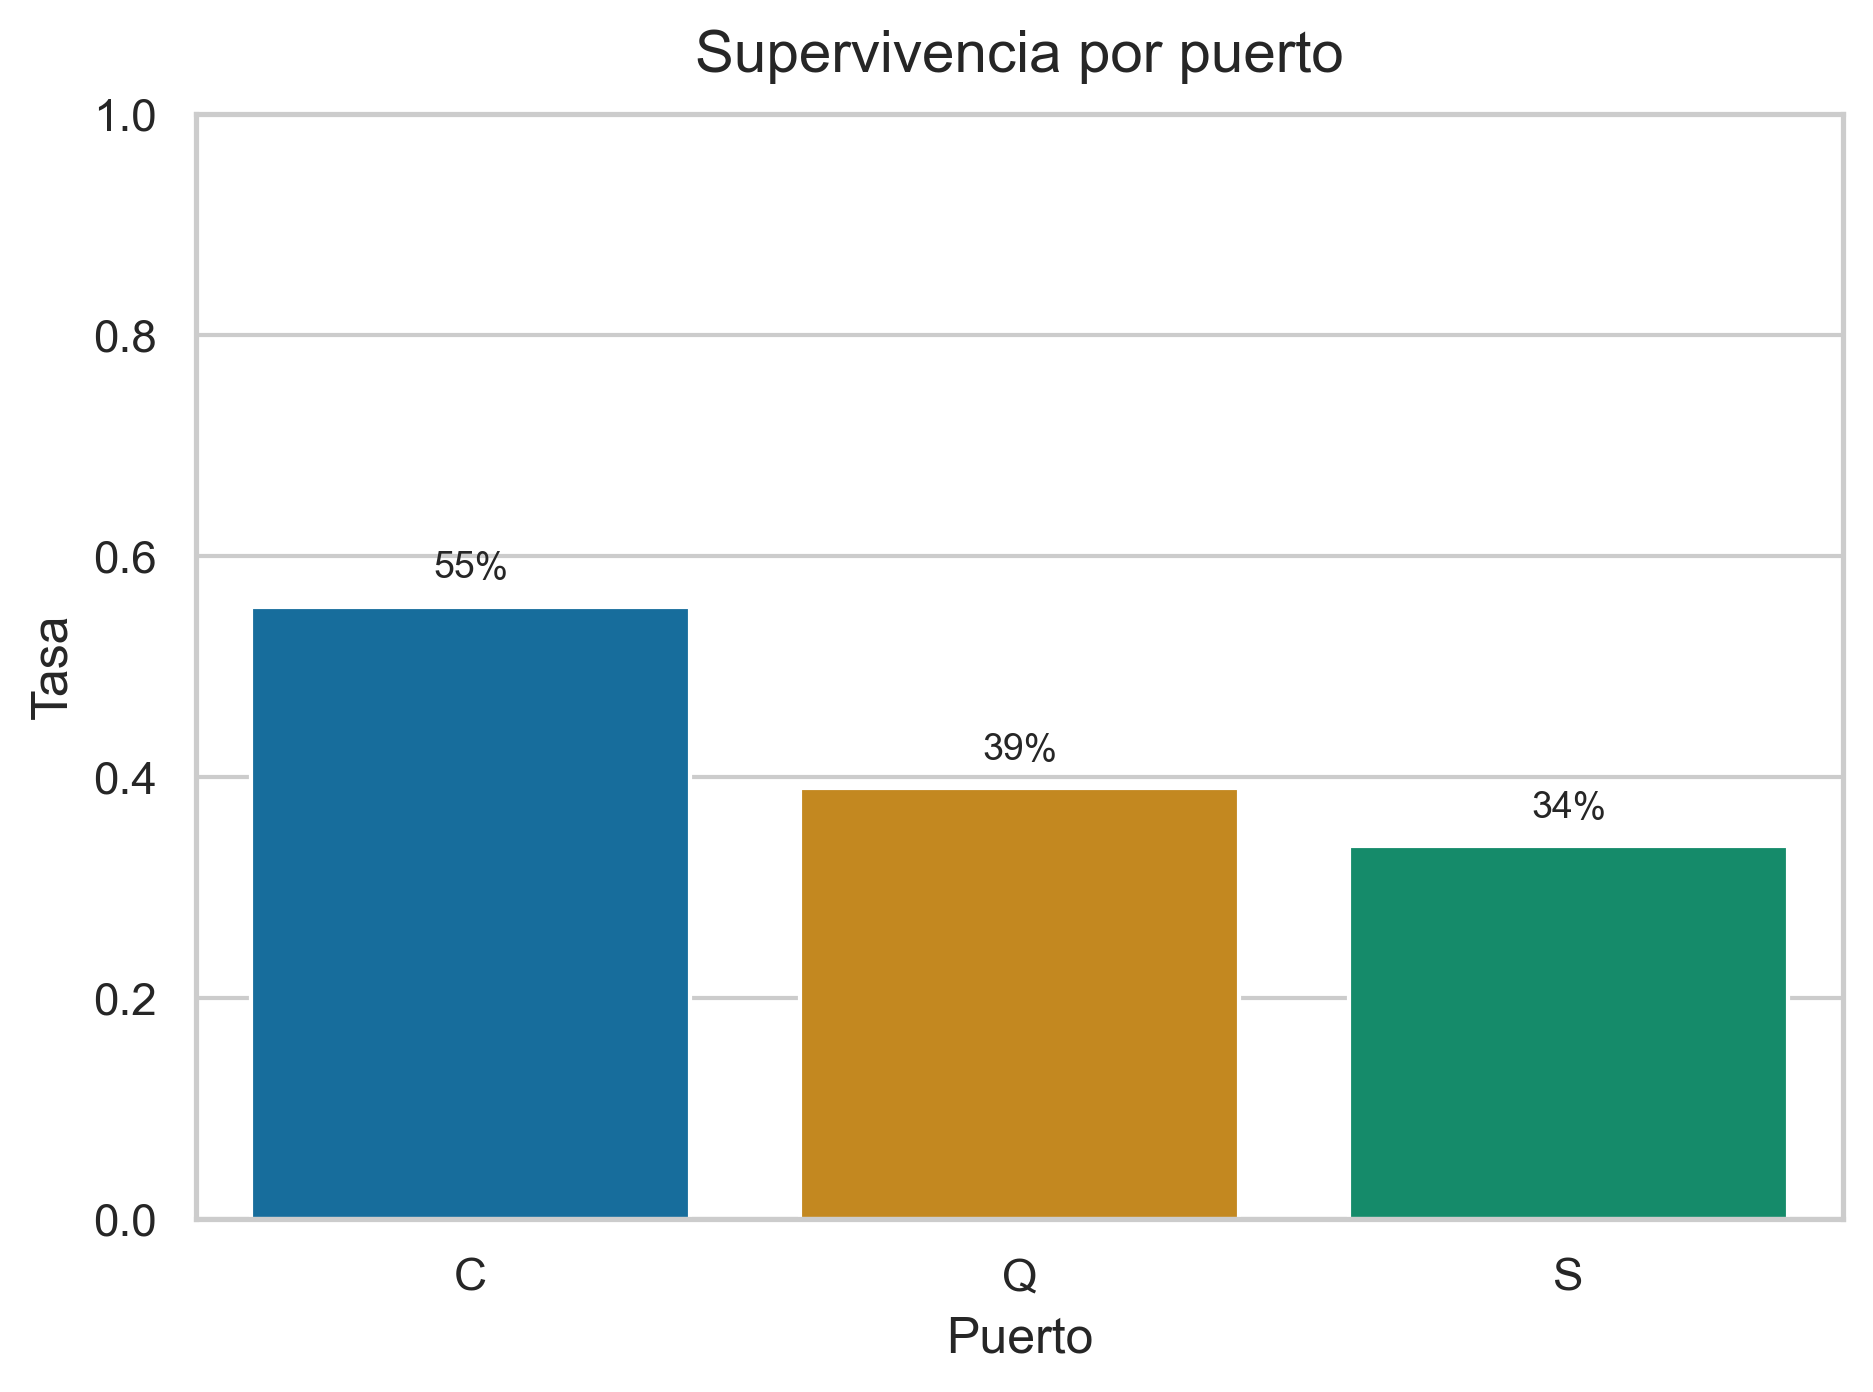

C:\Users\luigu\AppData\Local\Temp\ipykernel_376\3840323632.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_by_agebin = df.groupby("Age_bin")[SURV].mean()
c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=s.index.astype(str), y=s.values, ax=ax, palette=CB_PALETTE)
c:\Users\luigu\OneDrive\Escritorio\Titanic_MLProject\src\visualization.py:53: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.barplot(x=s.index.astype(str), y=s.values, ax=ax, palette=CB_PALETTE)


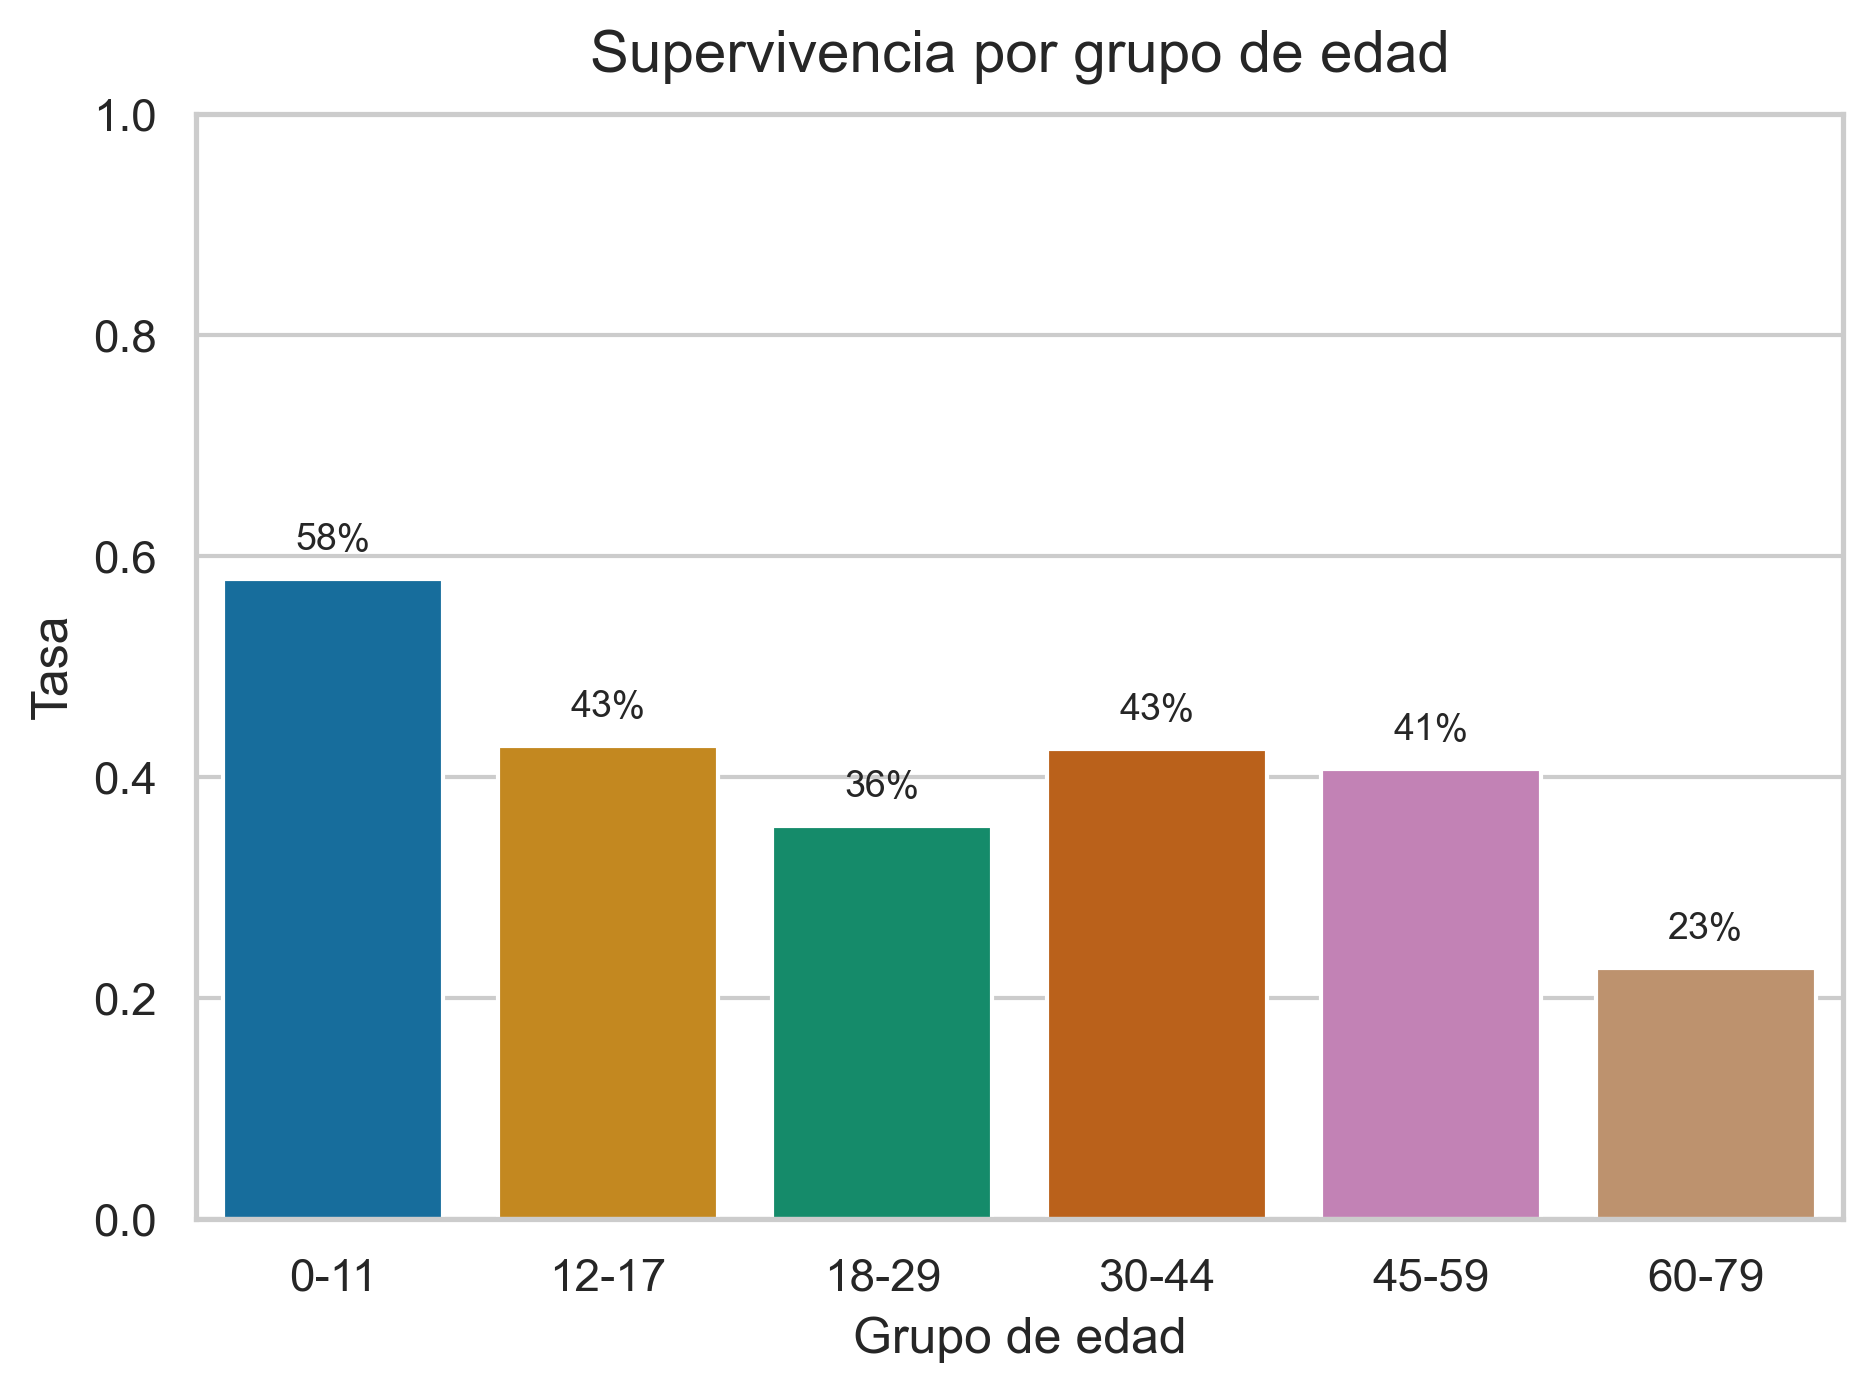

In [47]:
tables = {}

if SURV and SEX:
    rate_by_sex = df.groupby(SEX)[SURV].mean().sort_values(ascending=False)
    tables["survival_by_sex"] = rate_by_sex.reset_index().rename(columns={SURV:"survival_rate"})
    save_table(tables["survival_by_sex"], "eda_survival_by_sex", "Tasa de supervivencia promedio por sexo.")
    path = plot_rate_bar(
        rate_by_sex, name="survival_rate_by_sex",
        title="Supervivencia por sexo", xlabel="Sexo", ylabel="Tasa",
        caption="Brecha marcada: mujeres con ventaja por protocolos de evacuación."
    )
    display(Image(filename=str(path)))

if SURV and PCLASS:
    rate_by_pclass = df.groupby(PCLASS)[SURV].mean().sort_values(ascending=False)
    tables["survival_by_pclass"] = rate_by_pclass.reset_index().rename(columns={SURV:"survival_rate"})
    save_table(tables["survival_by_pclass"], "eda_survival_by_pclass", "Tasa de supervivencia promedio por clase.")
    path = plot_rate_bar(
        rate_by_pclass, name="survival_rate_by_pclass",
        title="Supervivencia por clase", xlabel="Clase", ylabel="Tasa",
        caption="1ra clase con mayor supervivencia; refleja ubicación de cabinas, acceso a cubierta y botes."
    )
    display(Image(filename=str(path)))

if SURV and EMB:
    rate_by_emb = df.groupby(EMB)[SURV].mean().sort_values(ascending=False)
    tables["survival_by_embarked"] = rate_by_emb.reset_index().rename(columns={SURV:"survival_rate"})
    save_table(tables["survival_by_embarked"], "eda_survival_by_embarked", "Tasa de supervivencia promedio por puerto.")
    path = plot_rate_bar(
        rate_by_emb, name="survival_rate_by_embarked",
        title="Supervivencia por puerto", xlabel="Puerto", ylabel="Tasa",
        caption="Patrón indirecto socioeconómico: Cherbourg tiende a embarcar más pasajeros de mayor clase."
    )
    display(Image(filename=str(path)))

if SURV and ("Age_bin" in df.columns):
    rate_by_agebin = df.groupby("Age_bin")[SURV].mean()
    tables["survival_by_agebin"] = rate_by_agebin.reset_index().rename(columns={SURV:"survival_rate"})
    save_table(tables["survival_by_agebin"], "eda_survival_by_agebin", "Tasa de supervivencia por grupos de edad.")
    path = plot_rate_bar(
        rate_by_agebin, name="survival_rate_by_agebin",
        title="Supervivencia por grupo de edad", xlabel="Grupo de edad", ylabel="Tasa",
        caption="Niñoz con ventaja relativa; disminuye en adultos mayores.",
        order=["0-11","12-17","18-29","30-44","45-59","60-79"]
    )
    display(Image(filename=str(path)))

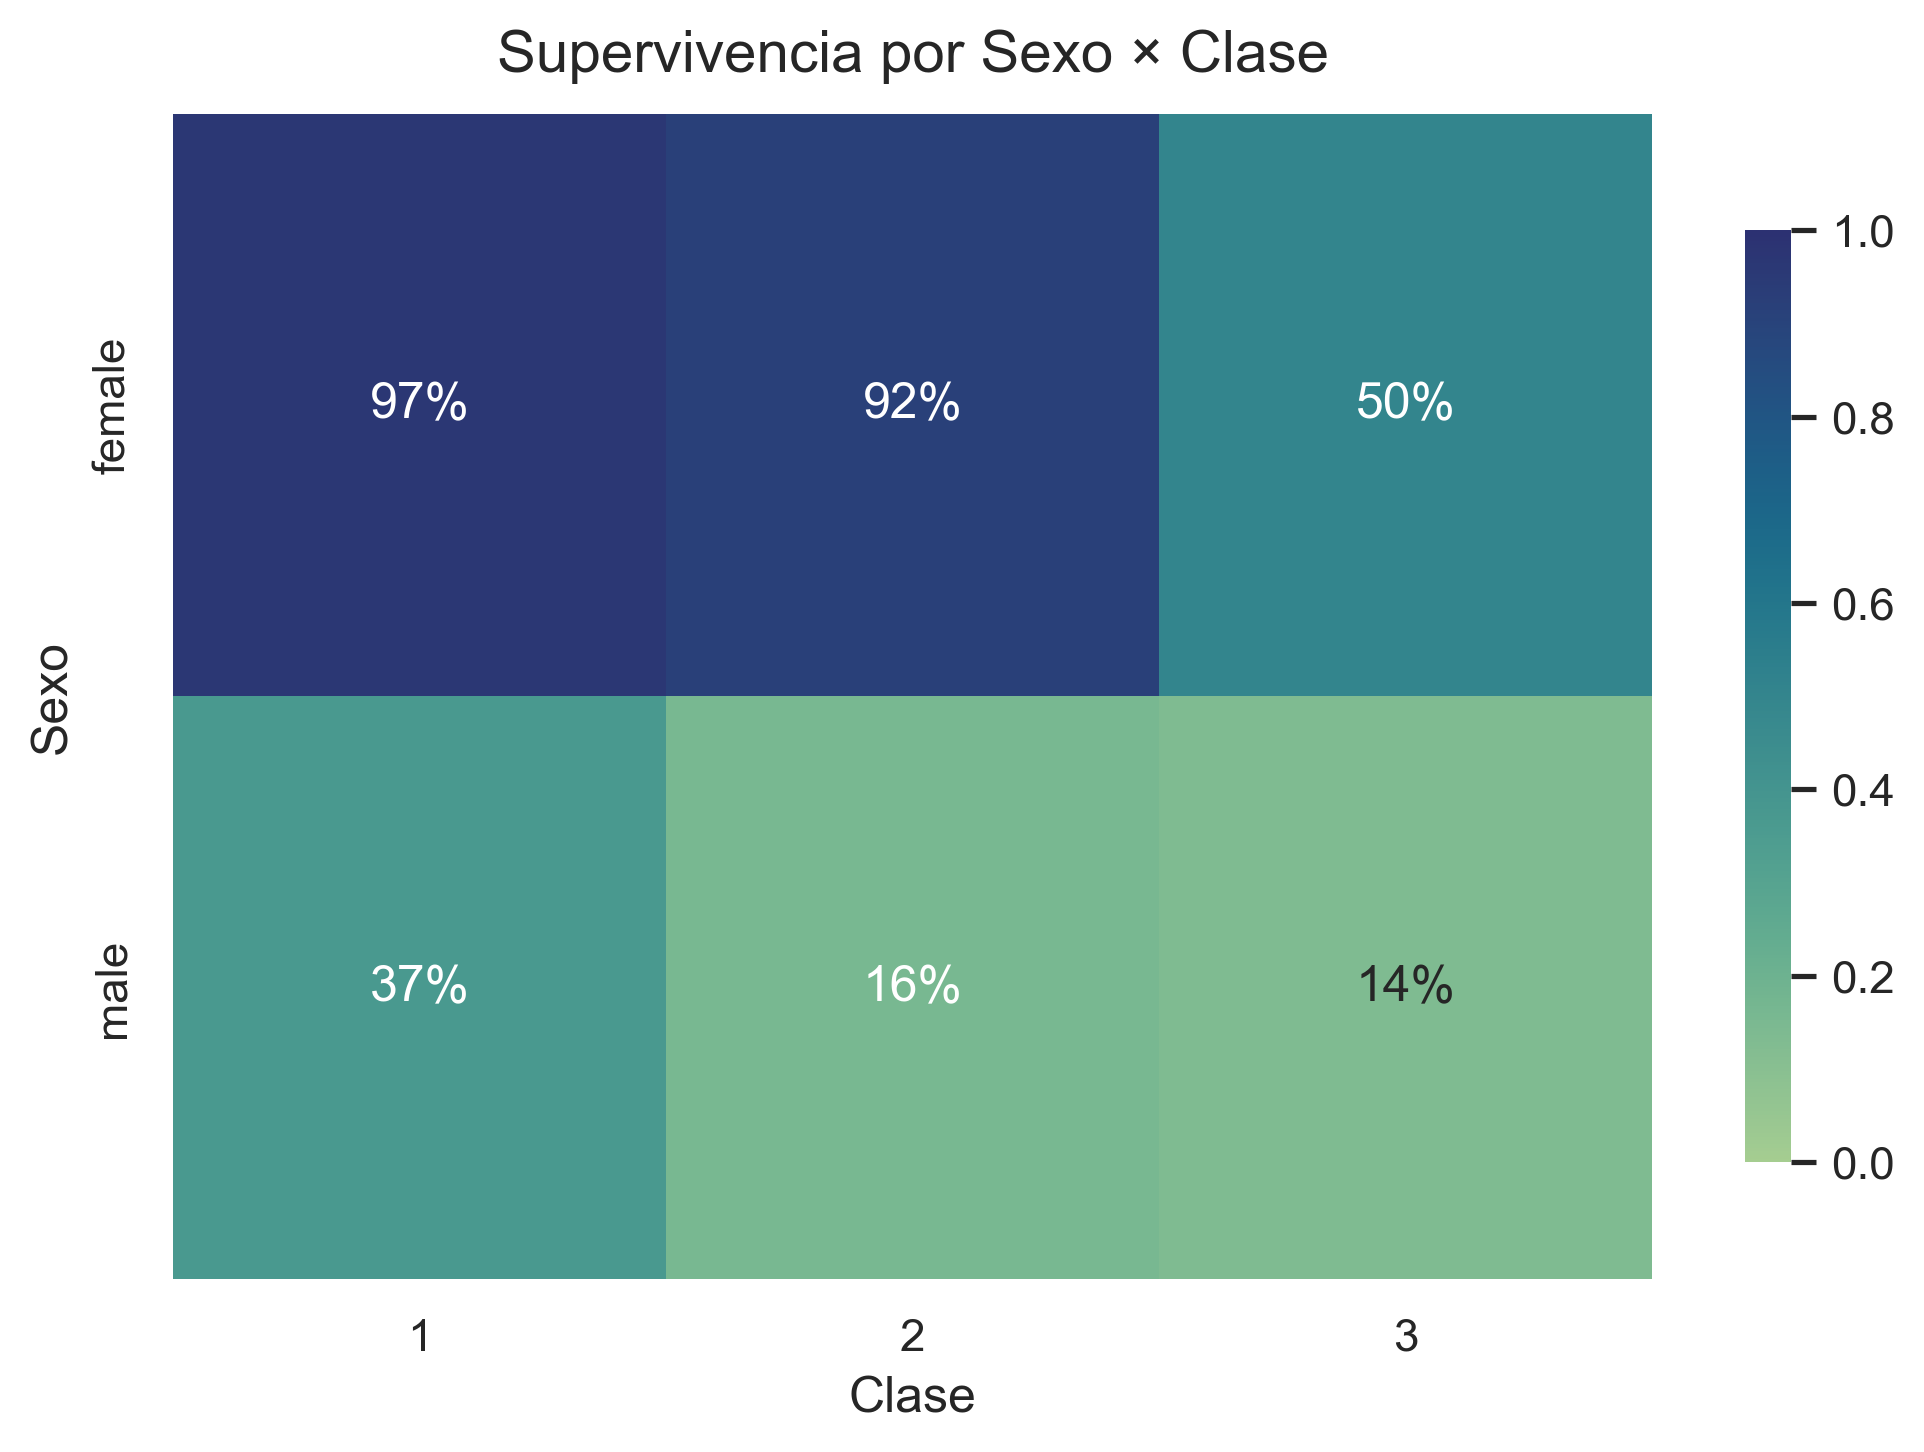

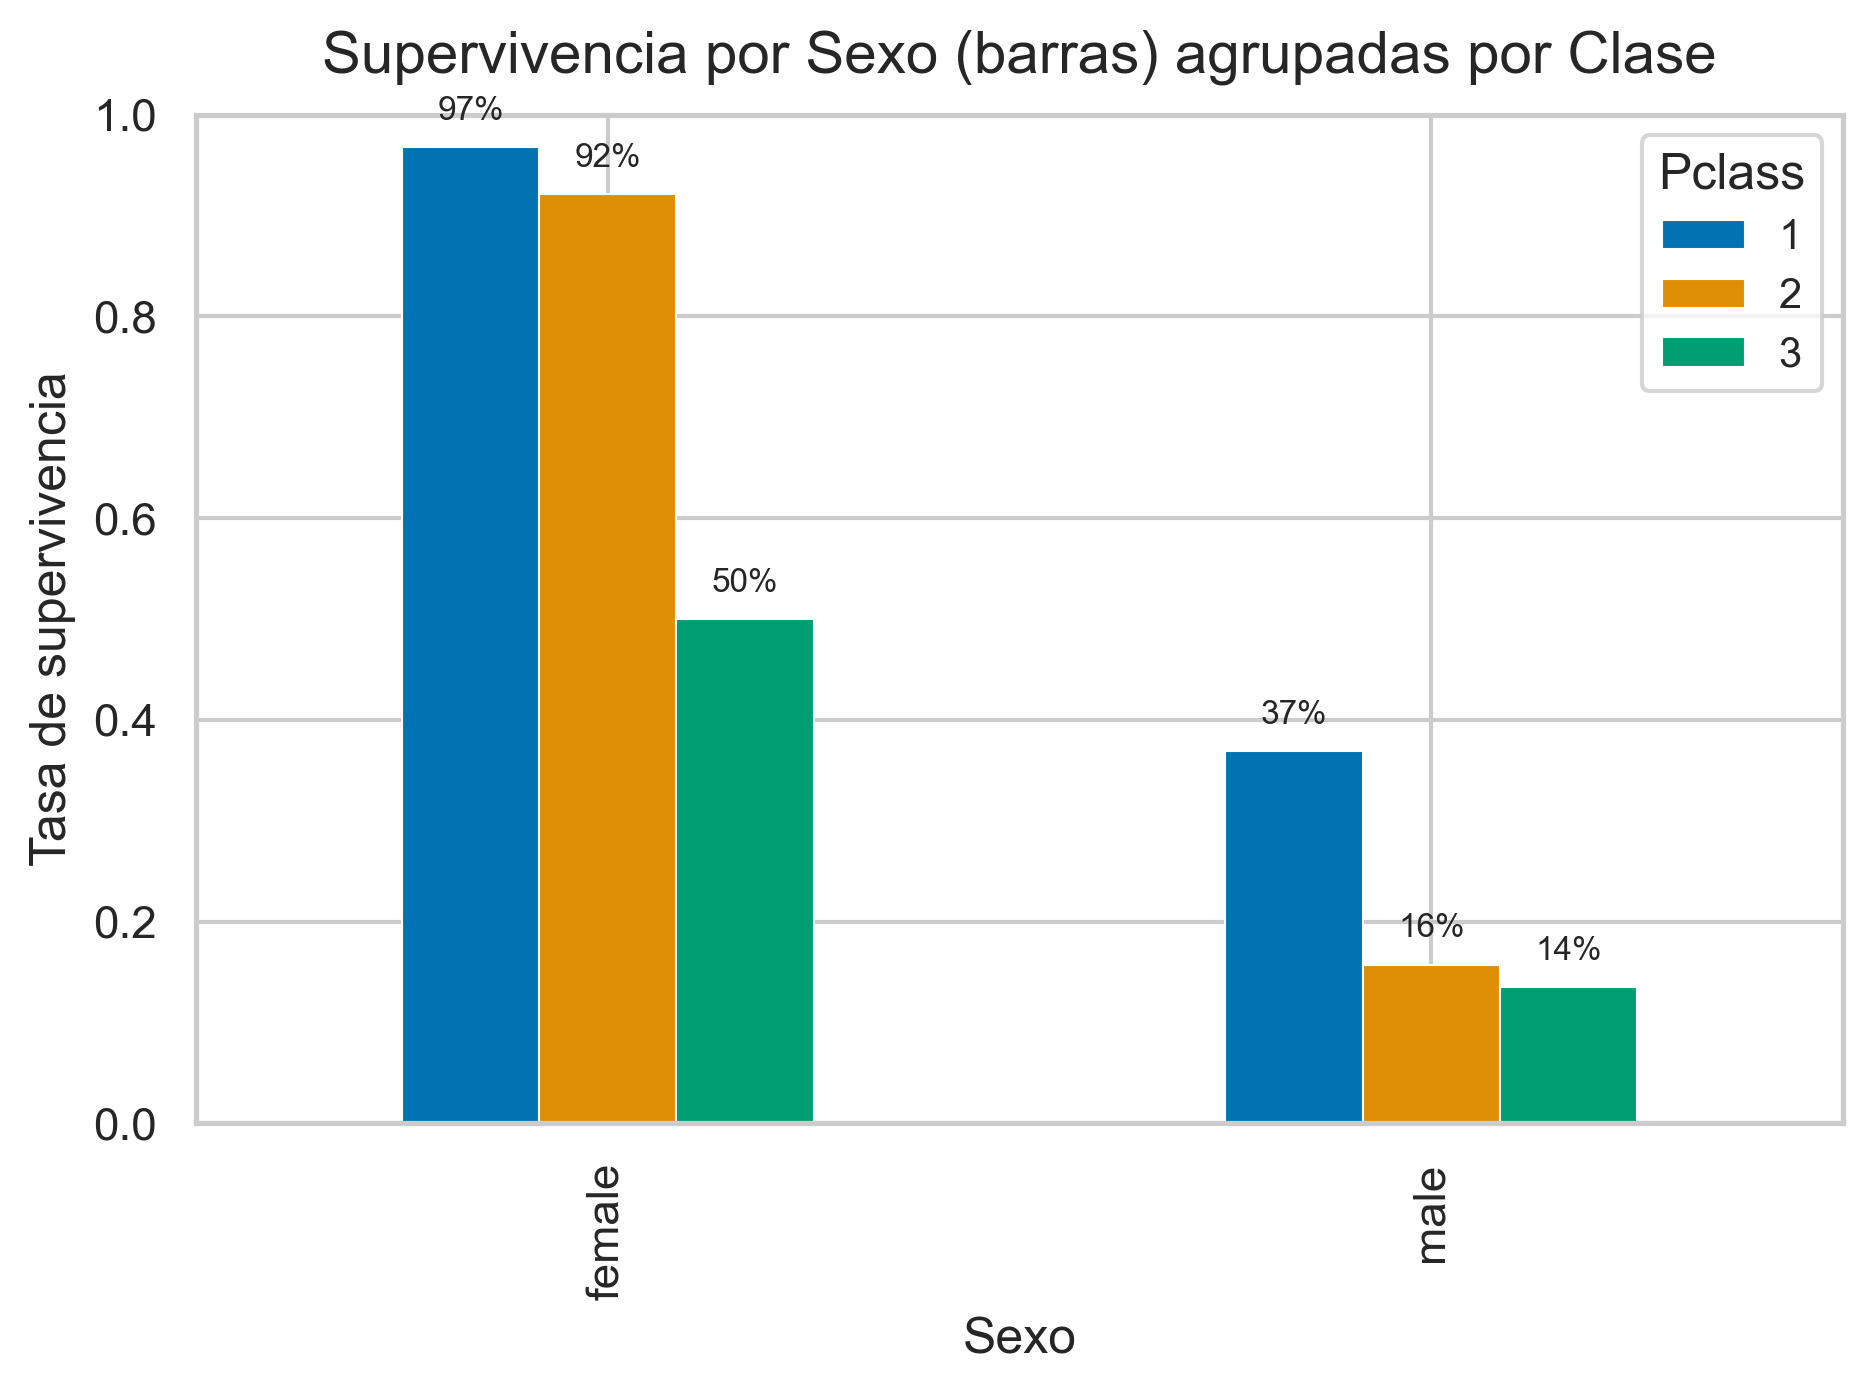

C:\Users\luigu\AppData\Local\Temp\ipykernel_376\1954252185.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_age_sex = df.groupby(["Age_bin", SEX])[SURV].mean().unstack(SEX)


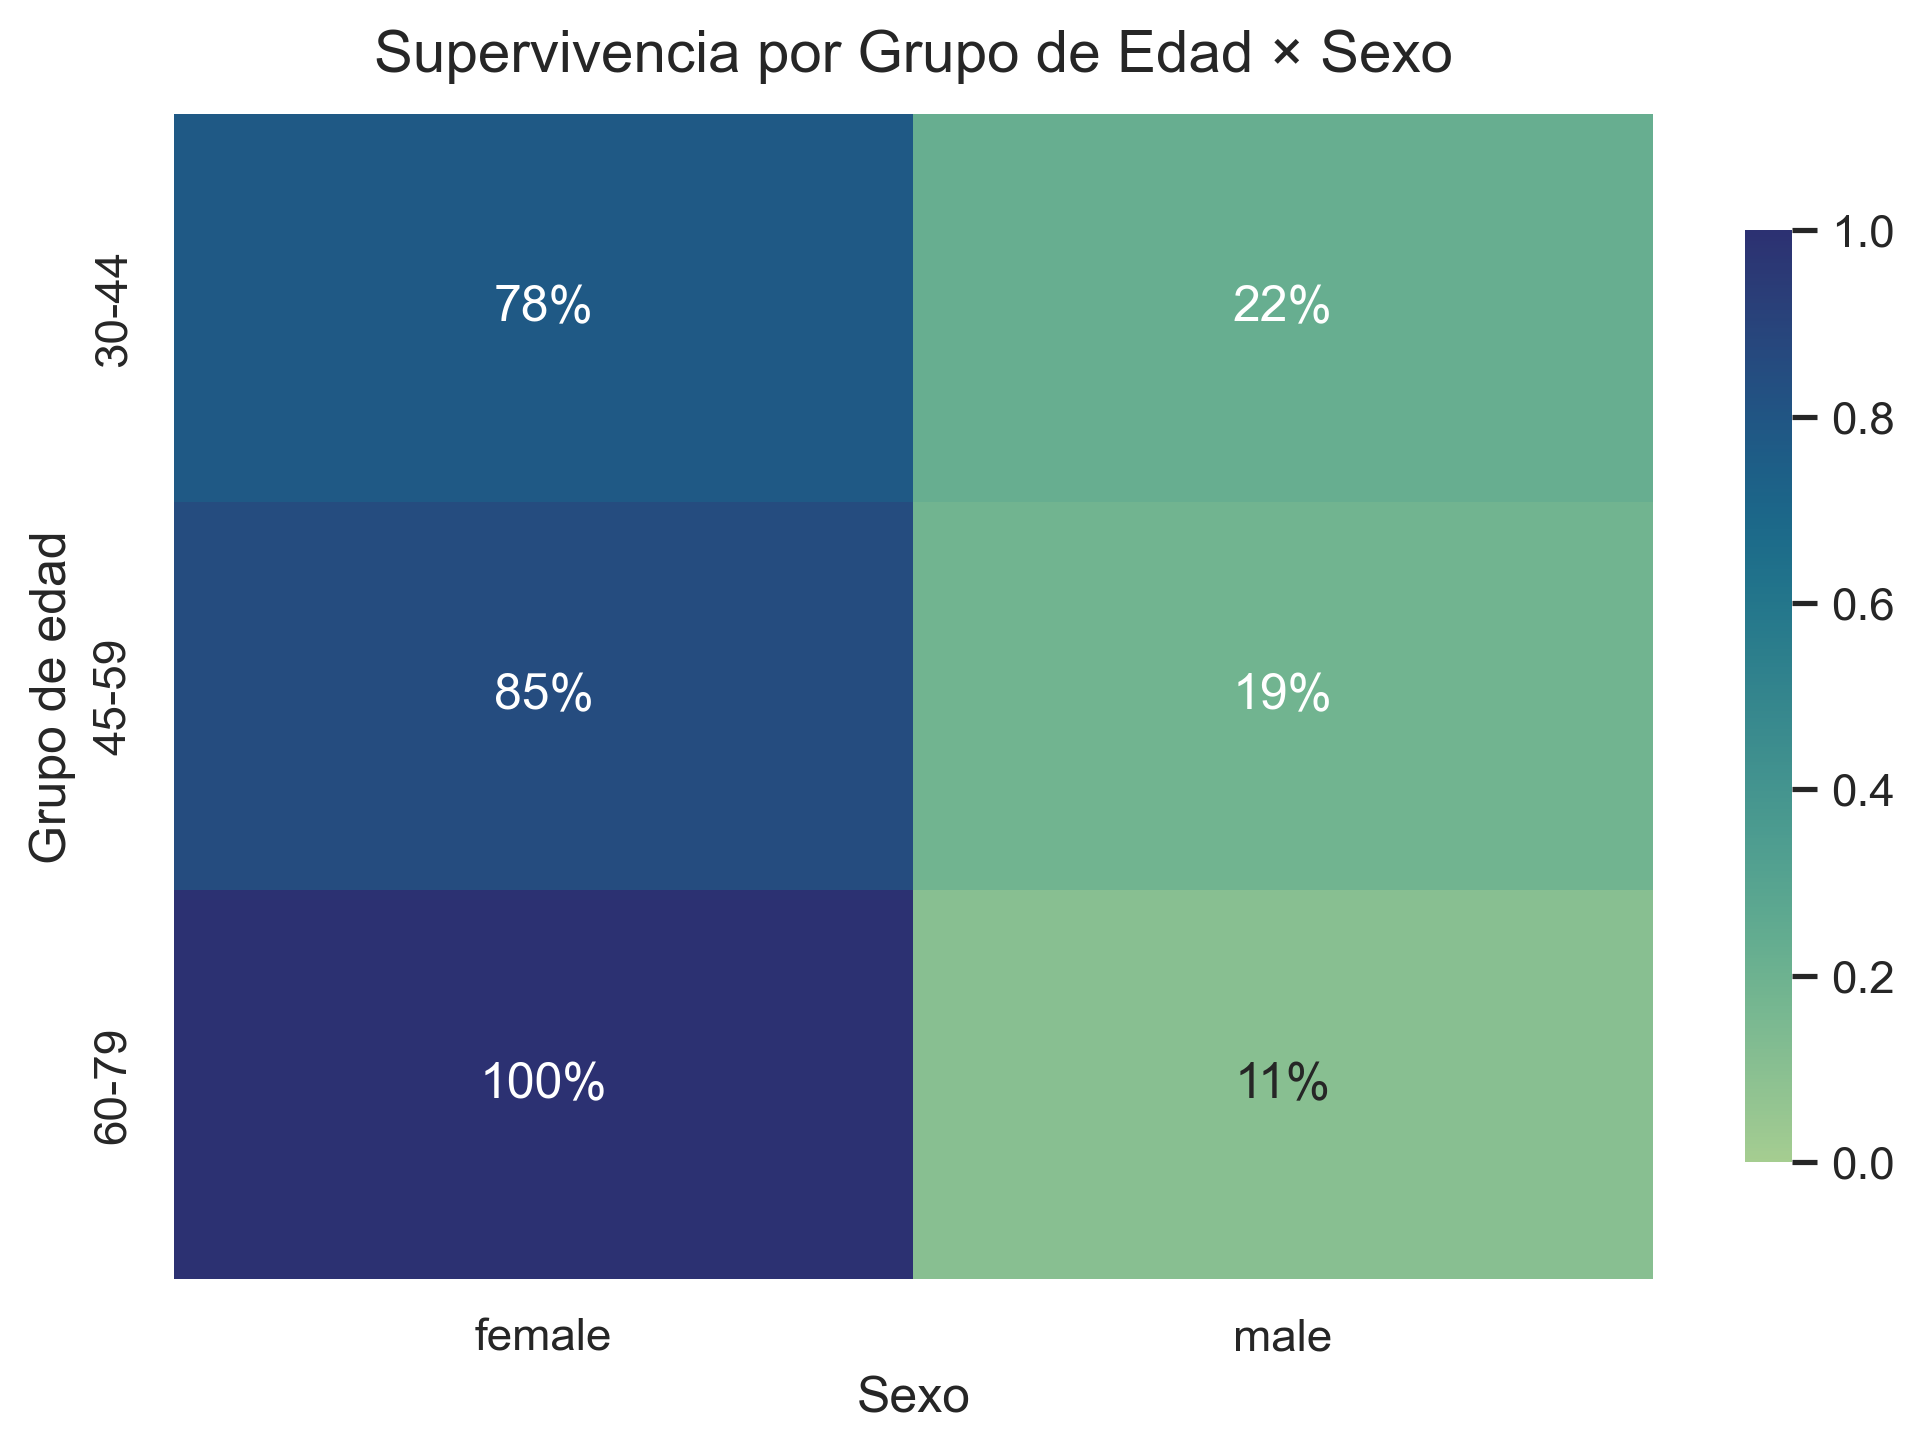

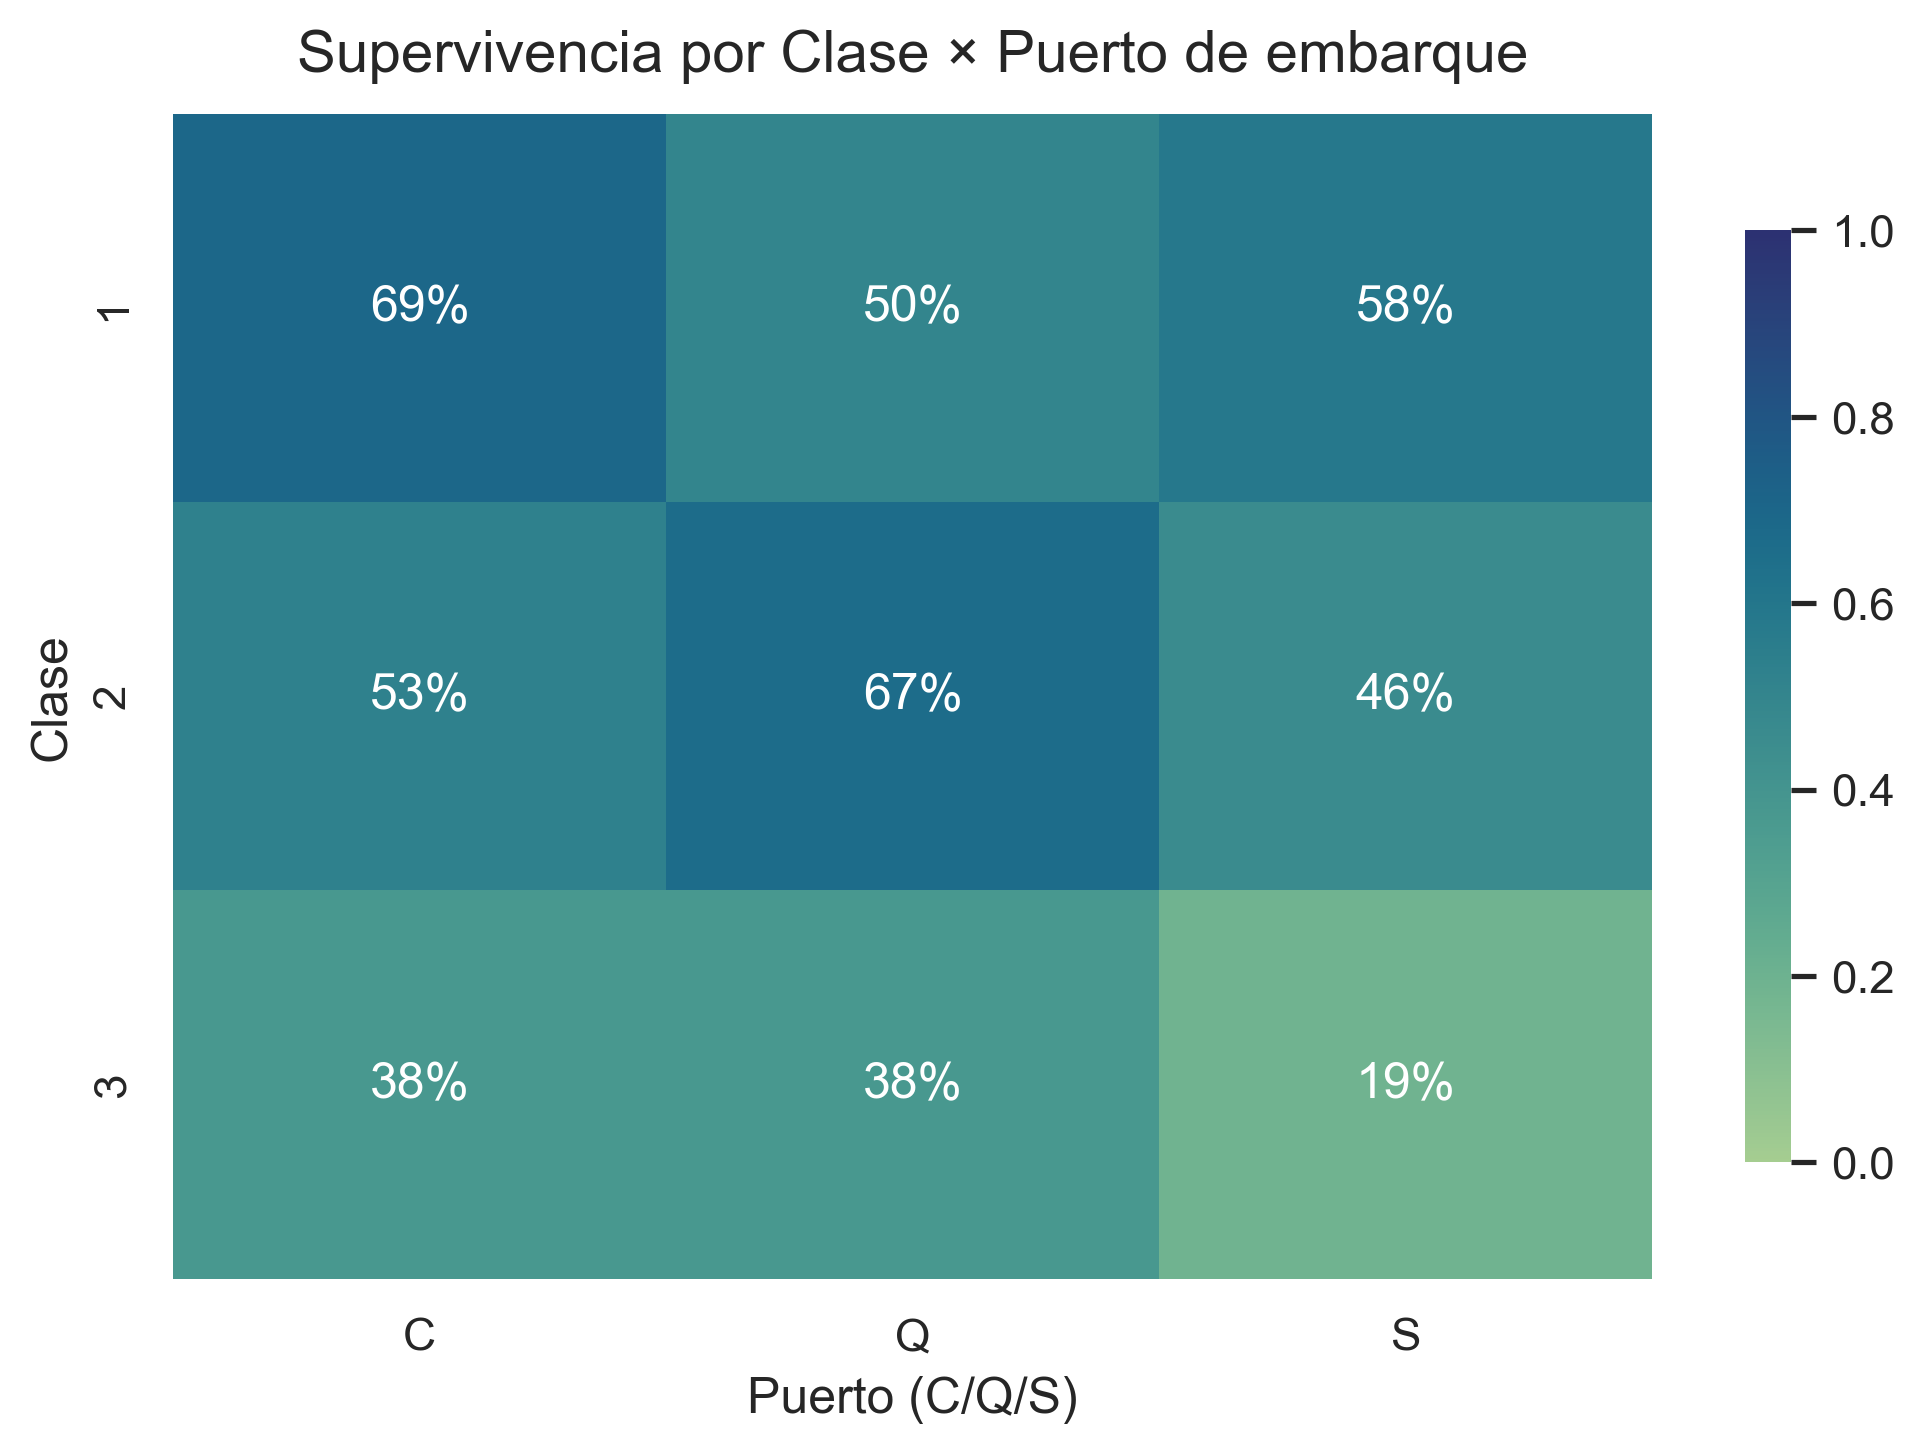

C:\Users\luigu\AppData\Local\Temp\ipykernel_376\1954252185.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_pclass_fareq = df_tmp.groupby([PCLASS, "_FareQ"])[SURV].mean().unstack("_FareQ")


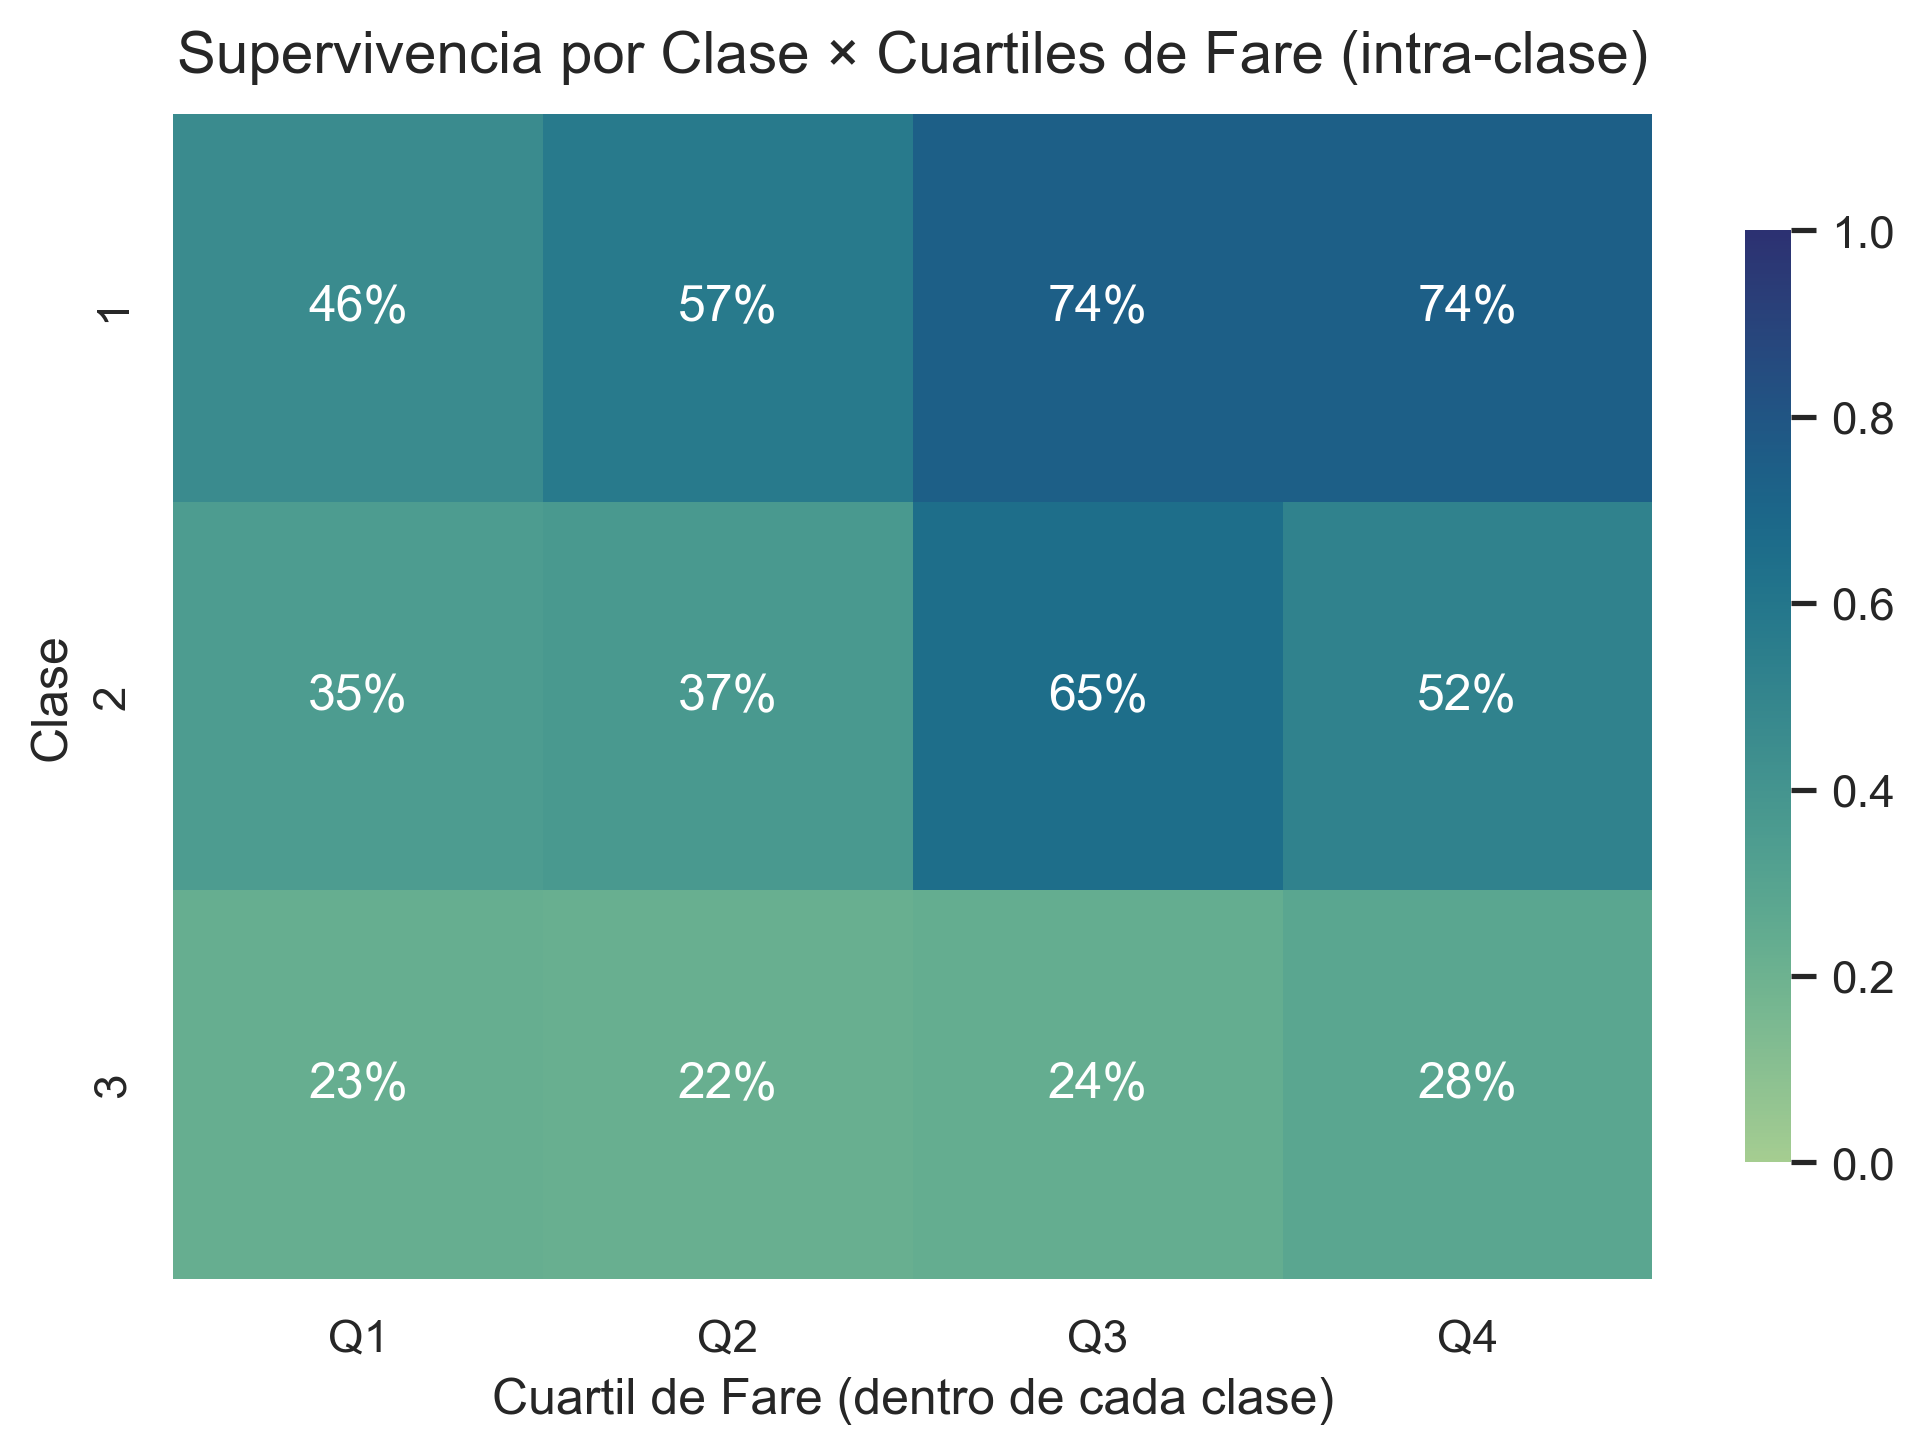

In [48]:
# Helpers para órdenes consistentes
sex_order = [x for x in ["female", "male"] if SEX and x in df[SEX].astype(str).unique()]
agebin_order = ["Niñez","Adolesc.","20-29","30-44","45-59","60-79"]
pclass_order = sorted(df[PCLASS].dropna().unique()) if PCLASS else None
emb_order = [x for x in ["C","Q","S"] if EMB and x in df[EMB].astype(str).unique()]

# 1) Sex × Pclass
if SURV and SEX and PCLASS:
    pivot_sex_pclass = df.groupby([SEX, PCLASS])[SURV].mean().unstack(PCLASS)
    if sex_order: pivot_sex_pclass = pivot_sex_pclass.reindex(index=sex_order)
    if pclass_order is not None: pivot_sex_pclass = pivot_sex_pclass.reindex(columns=pclass_order)
    path_hm = plot_survival_heatmap(
        pivot_sex_pclass,
        name="survival_heatmap_sex_pclass",
        title="Supervivencia por Sexo × Clase",
        xlabel="Clase",
        ylabel="Sexo",
        caption="Las mujeres en 1ra y 2da clase presentan las tasas más altas; los hombres en 3ra clase, las más bajas."
    )
    display(Image(filename=str(path_hm)))

    path_grp = plot_grouped_rate_bars(
        pivot_sex_pclass,
        name="survival_groupedbar_sex_pclass",
        title="Supervivencia por Sexo (barras) agrupadas por Clase",
        xlabel="Sexo",
        ylabel="Tasa de supervivencia",
        caption="Barras agrupadas que refuerzan el efecto conjunto de sexo y clase en la supervivencia."
    )
    display(Image(filename=str(path_grp)))

# 2) Age_bin × Sex
if SURV and ("Age_bin" in df.columns) and SEX:
    pivot_age_sex = df.groupby(["Age_bin", SEX])[SURV].mean().unstack(SEX)
    pivot_age_sex = pivot_age_sex.reindex(index=[x for x in agebin_order if x in pivot_age_sex.index])
    if sex_order:
        pivot_age_sex = pivot_age_sex.reindex(columns=sex_order)
    path_hm = plot_survival_heatmap(
        pivot_age_sex,
        name="survival_heatmap_agebin_sex",
        title="Supervivencia por Grupo de Edad × Sexo",
        xlabel="Sexo",
        ylabel="Grupo de edad",
        caption="Niñez destaca en supervivencia, especialmente en mujeres; la tasa disminuye en adultos mayores."
    )
    display(Image(filename=str(path_hm)))

# 3) Pclass × Embarked
if SURV and PCLASS and EMB:
    pivot_pclass_emb = df.groupby([PCLASS, EMB])[SURV].mean().unstack(EMB)
    if pclass_order is not None:
        pivot_pclass_emb = pivot_pclass_emb.reindex(index=pclass_order)
    if emb_order:
        pivot_pclass_emb = pivot_pclass_emb.reindex(columns=emb_order)
    path_hm = plot_survival_heatmap(
        pivot_pclass_emb,
        name="survival_heatmap_pclass_embarked",
        title="Supervivencia por Clase × Puerto de embarque",
        xlabel="Puerto (C/Q/S)",
        ylabel="Clase",
        caption="Cherbourg (C) suele asociarse a mayor supervivencia vía mezcla de clases más altas."
    )
    display(Image(filename=str(path_hm)))

# 4) Fare quantiles dentro de Pclass (cuartiles por clase)
if SURV and PCLASS and FARE:
    # Cuartiles de Fare por clase (manejo de empates con rank para evitar bins vacíos)
    df_tmp = df.copy()
    def qlabels(q): return [f"Q{i}" for i in range(1, q+1)]
    df_tmp["_FareQ"] = (
        df_tmp.groupby(PCLASS)[FARE]
        .transform(lambda s: pd.qcut(s.rank(method="first"), 4, labels=qlabels(4)))
    )
    pivot_pclass_fareq = df_tmp.groupby([PCLASS, "_FareQ"])[SURV].mean().unstack("_FareQ")
    if pclass_order is not None:
        pivot_pclass_fareq = pivot_pclass_fareq.reindex(index=pclass_order)
    path_hm = plot_survival_heatmap(
        pivot_pclass_fareq,
        name="survival_heatmap_pclass_fare_quartiles",
        title="Supervivencia por Clase × Cuartiles de Fare (intra-clase)",
        xlabel="Cuartil de Fare (dentro de cada clase)",
        ylabel="Clase",
        caption="Incluso dentro de la misma clase, los pasajeros en cuartiles de tarifa más altos muestran mayor supervivencia."
    )
    display(Image(filename=str(path_hm)))

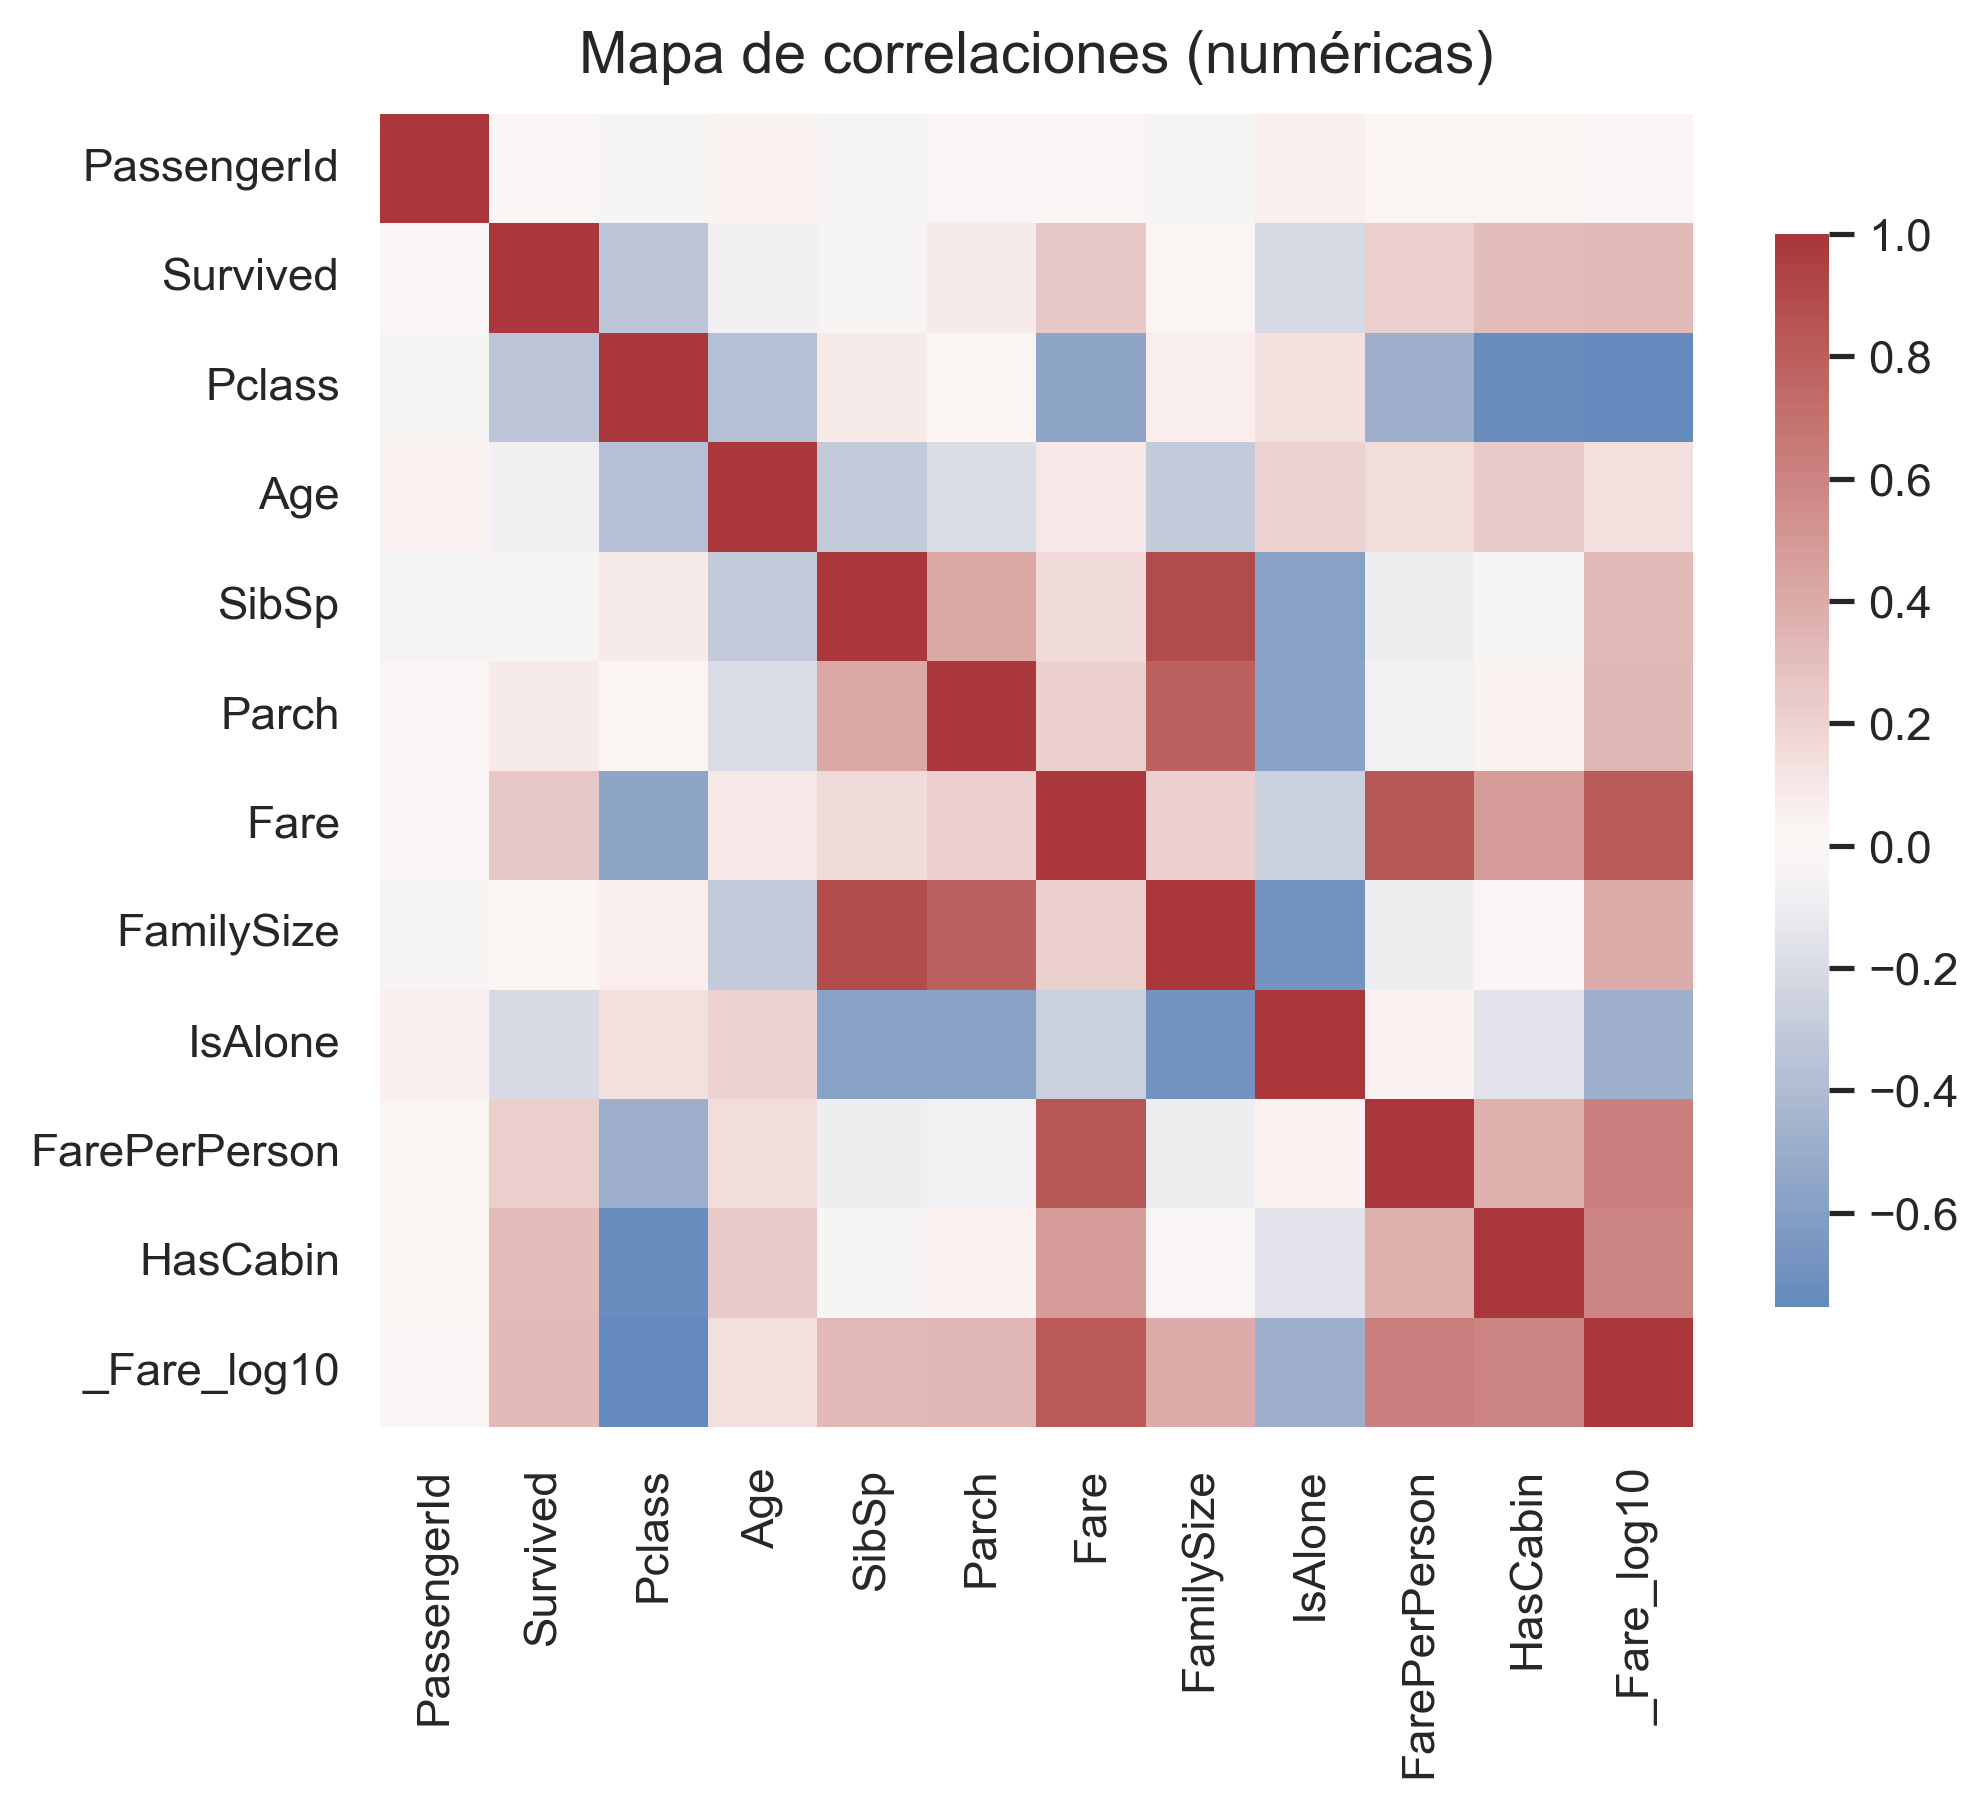

In [49]:
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
if len(num_cols) >= 2:
    path = plot_corr_heatmap(
        df[num_cols], name="corr_numeric",
        title="Mapa de correlaciones (numéricas)",
        caption="Relaciones lineales entre variables numéricas; útil para detectar redundancias y preparar el modelado."
    )
    display(Image(filename=str(path)))

## Conclusiones rápidas

- **Calidad de datos:** `Cabin` muy incompleto; `Age` con ~20% faltante.  
- **Distribuciones:** `Fare` altamente asimétrica → usar escala log; predominio de pasajeros en 3ra clase y sexo masculino.  
- **Relaciones clave:** la **supervivencia** se asocia fuertemente a **sexo** y **clase**; la **edad** muestra efecto no lineal (niños > seniors).  
- **Siguientes pasos:** imputación informada de `Age` (por `Title`, `Sex`, `Pclass`), transformar `Fare`, usar `FamilySize`, `IsAlone`, `HasCabin`, `Title` y probar interacciones (`Sex×Pclass`, `Age_bin×Pclass`).